The goal of this notebook is to generate the figures from Hudson and Miller 2025, "From Sailors to Satellites: A Curated Database of Bioluminescent Milky Seas from 1600s to Present".

In [1]:
###### IMPORTS GO HERE ######
## STANDARD LIBRARIES ##
import datetime as dt
import os
from PIL import Image
## PUBLIC LIBRARIES ##
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from global_land_mask import globe
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import numpy.ma as ma
import pandas as pd
from pyproj import Geod
import xarray as xr
## PRIVATE LIBARIES ##
import bootstrapping as bs
import dmi_cc_correction as dcc
import gsd_coarsener as gsdc

The lines below set-up access to the data needed to generate the figures. Some filepaths are filled with placeholders and will need to be changed to match those on your local machine.

In [2]:
# Paths for data
## This is for the database itself, used in multiple figures
database_path = './DATA/Supplemental_2.tsv'
## This is for the observed winds/SSTs from the data
## Used for Figure 8
observed_env_path = './DATA/Winds_and_Temps_From_Obs.csv'
## This is for the Niño 3.4 index data, it downloads it from NOAA PSL
Nino_34_Index_url = 'https://psl.noaa.gov/gcos_wgsp/Timeseries/Data/nino34.long.anom.data'
## This is for HadISST SST data from 1870-Present
## for Figure 8 as well as Figures 9-12
HadISST_path = './DATA/HadISST_sst.nc'
## This is for ERA5 850 and 200 hPa winds
## for Figures 9-12
ERA5_Webster_Yang_Winds_path = './DATA/WY_ERA5_850hPa_200hPa_winds.nc'
## This is for ERA5 850 hPA winds
## for Figures 9-12
ERA5_AUSMI_Winds_path = './DATA/AUSMI_ERA5_850hPa_winds.nc'
## This is for ETA5 1000 hPa winds over the NWIO/Arabian Sea
## for Figure 8
ERA5_NWIO_1000hPa_Winds_path = './DATA/NWIO_Environmental_ERA5_1000hPa_winds.nc'
## This is for
## This is for Shiptracking data from the Worldseaborne Trade Monitoring
## System (WSTMS) for Figures 5 and 6.
## Ensure you have downloaded the data from the IMF and placed the extracted folder
## into the DATA folder
WSTMS_loadpath = './DATA/shipdensity_global/shipdensity_global.tif'
WSTMS_savepath = './DATA/'

The cells below define various classes used in this notebook

In [3]:
class Marsden_Square:
    '''
        Defines a class based on the old Marsden Square system to count how
        many occurences of a milky sea occur within certain geographic bounds

        https://en.wikipedia.org/wiki/Marsden_square
    '''
    def __init__(self,west_edge,south_edge) -> None:
        '''
            Initializes a Marsden_Square object based upon the location of the
            western and southern edges of the square.

            Parameters:
                west_edge (float): The western edge of the square in degrees Longitude
                south_edge (float): The southern edge of the square in degrees Latitude
            
            Returns:
                None
        '''
        self.width = 15
        self.height = 15
        self.west_edge = west_edge
        self.south_edge = south_edge
        self.num_points = 0
    
    def check_if_point_in_square(self,point_lat,point_lon) -> None:
        '''
        Checks if a point is inside the defined Marsden square. 
        If so increase its point counter by 1
        
        Parameters:
            point_lat (float): The latitude of the point I want to check is inside the 
                Marsden_Square object

            point_lon (float): The longitude of the point I want to check is inside the
                Marsden_Square object
        
        Returns:
            None
        '''
        if point_lon >= self.west_edge and point_lon < self.west_edge+self.width:
            if point_lat >= self.south_edge and point_lat < self.south_edge+self.height:
                self.num_points+=1

In [4]:
class Event:
    '''
        Defines a class that combines observations int milky sea events, whether that be from
        eyewitness accounts, satellite observations, or both.

    '''
    def __init__(self,start_date,end_date,start_lat,start_lon,start_code,start_area,max_day,max_dist) -> None:
        '''
            Initializes an Event object using a single observation from the database and the
            thresholds for adding new observations to the event.

            Parameters:
                start_date (dt.datetime): The timestamp corresponding to the start of the observation
                end_date (dt.datetime): The timestampe corresponding to the end of the observation if it exists
                start_lat (float): The latitude corresponding to the observation [-90 -> 90]
                start_lon (float): The longitude corresponding to the observation [-180 -> 180]
                start_code (int): The confidence code for the observation from the database
                start_area (float): The satellite derived area if it exists in the database
                max_day (int): The threshold for the maximum number of days for new observations to be added to the event
                max_dist (float): The threshold for the maximum distance for new observations to be added to the event
            
            Returns:
                None
        '''
        # set the start/end date, if no end date exists just use the start date
        self.start_date = start_date
        if type(end_date) == dt.datetime:
            self.end_date = end_date
        else:
            self.end_date = start_date
        # make an array containing all dates associated with the event
        self.dates = [self.start_date,self.end_date]
        # arrays for holding all locations associated with the events
        self.lons = [start_lon]
        self.lats = [start_lat]
        # array for the confidence codes assoced with all obs in an event
        self.ev_codes = [start_code]
        # track how many obs have been merged into this event
        self.num_obs = 1
        # set the thresholds for grouping new observations into the event
        self.max_day = max_day
        self.max_dist = max_dist
        # if there is a satellite derived area add it to the event, otherwise use a placeholder
        if start_area == 'N/A':
            self.area = -9999
            self.area_type = None
        else:
            self.area = float(start_area)
            self.area_type = 'Satellite'
    
    def distance(self,new_lat,new_lon) -> float:
        '''
            Calculates the distance in degrees between a new observation and the original observation
            used to create the event

            Parameters:
                new_lat (float): The latitude of the new observation
                new_lon (float): The longitude of the new observation
            
            Returns:
                dist (float): The distance between the new observation and the original observation
        '''
        return np.sqrt( (self.lons[-1] - new_lon)**2 + (self.lats[-1] - new_lat)**2)
    
    def consider_new_ob(self,new_start,new_end,new_lat,new_lon,ev_code,area) -> bool:
        '''
            Considers whether or not a new observation should be merged into this event.

            Parameters:
                new_start (dt.datetime): The timestamp corresponding to the start of the new observation
                new_end (dt.datetime): The timestamp corresponding to the end of the new observation
                new_lat (float): The latitude of the new observation
                new_lon (float): The longitude of the new observation
                ev_code (int): The confidence code of the new observation
                area (float): The satellite derived area of the new observation if it exists

            Returns:
                should_be_added (bool): Whether or not the new observation should be added to the event
        '''
        if np.abs((new_start - self.start_date).days) <= self.max_day and self.distance(new_lat,new_lon) <= self.max_dist:
            self.add_new_obs_details(new_start,new_end,new_lat,new_lon,ev_code,area)
            return True
        else:
            return False

    def add_new_obs_details(self,new_start,new_end,new_lat,new_lon,ev_code,area) -> None:
        '''
            Merges a new observation with the event.

            Parameters:
                new_start (dt.datetime): The timestamp corresponding to the start of the new observation
                new_end (dt.datetime): The timestamp corresponding to the end of the new observation
                new_lat (float): The latitude of the new observation
                new_lon (float): The longitude of the new observation
                ev_code (int): The confidence code of the new observation
                area (float): The satellite derived area of the new observation if it exists
            
            Returns:
                None
        '''
        # Add the new dates to self.dates
        self.dates.append(new_start)
        if type(new_end) == dt.datetime:
            self.dates.append(new_end)
        # Add the new lat/lons to self.lats and self.lons
        self.lons.append(new_lon)
        self.lats.append(new_lat)
        # Add the new ev_codes to self.ev_codes
        self.ev_codes.append(ev_code)
        # Increase the number of observations in the event
        self.num_obs += 1
        # Sort the dates by time and make the latest date the new self.end_date
        self.dates = sorted(self.dates)
        self.end_date = self.dates[-1]
        # If a satellite area is found and one isn't currently being used make it the new area.
        if area != 'N/A' and self.area == -9999:
            self.area = float(area)
    
    def set_polygon_area(self) -> None:
        '''
            For events with no satellite derived area and at least 3 observations estimate an area
            from a polygon composed of the locations of the observations.

            Parameters:
                None
            
            Returns:
                None
        '''
        if self.area == -9999 and self.num_obs >= 3 and self.area_type != 'Satellite':
            geod = Geod('+a=6378137 +f=0.0033528106647475126')
            poly_area, _ = geod.polygon_area_perimeter(self.lons, self.lats) #value is in meters^2
            self.area = np.abs(poly_area)/1000/1000 #converted to km^2 to match satellite values
            self.area_type = 'Calculated' #update the area type
    
        

The cell below defines the various functions used in this notebook to retrieve/process the data

In [5]:
def convert_dates(start_date_array:np.ndarray,end_date_array:np.ndarray) -> list:
    '''
        Converts dates from the database into a list of datetime objects
        to make them more usable.

        Parameters:
            start_date_array (np.ndarray): Numpy array containing the start dates as strings
            end_date_array (np.ndarray): Numpy array containing the end dates as strings
        
        Returns:
            start_conv_dates (list): The start dates converted to datetime objects
            end_conv_dates (list): The end dates converted to datetime objects
    '''

    # fill in missing end dates with the start date
    missing_end_dates = np.where(end_date_array == '(?)')
    end_date_array[missing_end_dates] = start_date_array[missing_end_dates]

    # convert the dates
    start_conv_dates = [dt.datetime.strptime(d,"%m/%d/%Y") for d in start_date_array]
    end_conv_dates = [dt.datetime.strptime(d,'%m/%d/%Y') for d in end_date_array]

    return start_conv_dates,end_conv_dates

def string_parser(loc_string:str) -> list:
    '''
    Parses a location string and returns the degrees, minutes, and direction that make it up.
    If the location string is S or W it will be converted to negative
    
    Parameters:
        loc_string (str): The location of an entry in the database as a string extracted
            from the .tsv file

    Returns:
        loc_list (list): A list containing the location in terms of degrees, minutes,
            and the direction in terms of N, S, E, W identifiers
            
    '''
    
    #0 is the number of degrees
    #1 is the word 'deg'
    #2 is the number of minutes followed by a '
    #3 is the N,S,E,W signifier

    split_string = loc_string.split(' ')

    num_degrees = float(split_string[0])
    num_minutes = float(split_string[2][:-1]) #this takes out the ' to signify minutes
    dir_signifier = split_string[3]

    loc_list = [num_degrees,num_minutes,dir_signifier]

    return loc_list

def convert_minutes_to_degrees(num_minutes:float) -> float:
    '''Given a number of minutes convert that to the fraction of degrees it represents
    and then return that value as a float.'''

    if num_minutes >= 60:
        raise ValueError("Number of Minutes in a degree can't be greater than 60.")
    elif num_minutes < 0:
        raise ValueError("Can't have negative minutes in a degree.")

    return num_minutes/60.

def get_direction_sign(dir_signifier:str) -> int:
    '''Based on the direction (N,S,E,W) return +/- 1 to multiply final result by.'''

    if dir_signifier == 'W' or dir_signifier == 'S':
        return -1
    else:
        return 1

def get_loc_in_degrees(loc_string:str) -> float:
    '''Takes in the locaction string and returns the coordinate on earth as a decimal -180 -> 180.'''
    parsed_string_list = string_parser(loc_string)
    minutes_in_decimal = convert_minutes_to_degrees(parsed_string_list[1])
    direction_sign = get_direction_sign(parsed_string_list[2])

    return direction_sign * (parsed_string_list[0]+minutes_in_decimal)

def create_Marsden_Square_Collection() -> list:
    '''
        Creates a collection of Marsden Squares which cover the globe
        and returns them as a list.

        Parameters:
            None
        
        Returns:
            square_collection (list): A list containing all of the generated
                Marsden Squares
    '''

    # make the edges for the square
    west_edges = np.arange(-180,180,15)
    south_edges = np.arange(-90,90,15)
    # create fill the square collection list
    square_collection = []
    for i in range(len(west_edges)):
        for j in range(len(south_edges)):
            square_collection.append(Marsden_Square(west_edges[i],south_edges[j]))
    
    return square_collection

def fill_Marsden_Square_Collection(square_collection:list,obs_lats:list,obs_lons:list) -> None:
    '''
        Fills the collection of marsden squares with the observations from the database

        Parameters:
            square_collection (list): A list containing the Marsden Square objects I
                instantiated
            
            obs_lats (list): A list containing the latitudes for each observation in the
                database
            
            obs_lons (list): A list containing the longitudes for each observation in the
                database
        
        Returns:
            None
    '''

    #loop through and fill the Marsden_Square objects
    for square in square_collection:
        for i in range(len(obs_lats)):
            square.check_if_point_in_square(obs_lats[i],obs_lons[i])
    
    return None

def box_classify(box_bounds:list,acc_lats:list,acc_lons:list,acc_months:list,acc_years:list) -> tuple[list]:
    '''
        Given a predefined region bounded by a box determine whether or not an account occurs
        within that box and if so save it.

        Parameters:
            box_bounds (list): The bounds of the box which defines the region [left,bottom,width,height]
            acc_lats (list): The latitudes for every account
            acc_lons (list): The longitudes for every account
            acc_months (list): The months for every account
            acc_years (list): The years for every account

        Returns:
            box_lats (list): The latitudes for every account in the box
            box_lons (list): The longitudes for every account in the box
            box_months (list): The months for every account in the box
            box_years (list): The years for every account in the box
    '''

    #define the lists we'll return
    box_lats = []
    box_lons = []
    box_months = []
    box_years = []
    #loop over the accounts
    for i in range(len(acc_lats)):
        #check if an account occurs within the box
        if acc_lons[i] >= box_bounds[0] and acc_lons[i] <= box_bounds[0] + box_bounds[2]:
            if acc_lats[i] >= box_bounds[1] and acc_lats[i] <= box_bounds[1] + box_bounds[3]:
                box_lats.append(acc_lats[i])
                box_lons.append(acc_lons[i])
                box_months.append(acc_months[i])
                box_years.append(acc_years[i])
    
    return box_lats,box_lons,box_months,box_years

def convert_F_to_C(temp:float) -> float:
    '''
        Converts a Fahrenheit Temperature to Celsius.

        Parameters:
            temp (float): Temperature in Fahrenheit
        
        Returns:
            c_temp (float): The temperature in Celsius
    '''

    c_temp = (temp - 32)*(5/9)

    return c_temp

def process_temps(temps:list) -> list:
    '''
        Processes the observed temperatures from milky sea accounts
        and returns them as a usable list.

        Parameters:
            temps (list): The list of temperatures to process
        
        Returns:
            processed_temps (list): The list of processed temperatures
    '''

    processed_temps = []
    for i in range(len(temps)):
        if temps[i] != 'NAN' and temps[i] != '':
            if temps[i][-1] == 'F':
                processed_temps.append(convert_F_to_C(float(temps[i][:-1])))
            else:
                process_temps.append(float(temps[i][:-1]))

    return processed_temps

def add_month_sums(month_sum_list:list,month_num:int,num_to_add:int) -> None:
    '''
        Modifies a list to produce how many times a month is noted to correspond to an
        observation within a database. This is used to recreate Herring and Watson 1993 plots

        Parameters:
            month_sum_list (list): The list to add data to
            month_num (int): The number of the month to add data for
            num_to_add (int): How many of the specified month to add to the list

        Returns:
            None
    '''

    for i in range(num_to_add):
        month_sum_list.append(month_num)

    return None

def load_NWIO_1000hPa_winds() -> tuple[np.ndarray]:
    '''
        Loads the ERA5 1000 hPa winds for the NWIO for Figure 8. These are limited
        to just July, August, and September which is the peak of milky sea sightings.
    '''
    # load the data
    nwio_u = Dataset(ERA5_NWIO_1000hPa_Winds_path).variables['u'][:,0,:,:]
    nwio_v = Dataset(ERA5_NWIO_1000hPa_Winds_path).variables['v'][:,0,:,:]
    nwio_lats = Dataset(ERA5_NWIO_1000hPa_Winds_path).variables['latitude'][:]
    nwio_lons = Dataset(ERA5_NWIO_1000hPa_Winds_path).variables['longitude'][:]
    # filter out bad data from the U and V fields
    nwio_u[np.where(nwio_u < -1000)] = np.nan
    nwio_v[np.where(nwio_v < -1000)] = np.nan

    return nwio_u,nwio_v,nwio_lats,nwio_lons

def limit_NWIO_winds_to_ocean(nwio_u,nwio_v,nwio_lats,nwio_lons) -> tuple[np.ndarray]:
    '''
        Uses the global_land_mask package to limit the NWIO winds to just the ocean.
    '''
    ocean_nwio_u = np.copy(nwio_u)
    ocean_nwio_v = np.copy(nwio_v)
    for i in range(len(nwio_lats)):
        for j in range(len(nwio_lons)):
            if globe.is_land(nwio_lats[i],nwio_lons[j]):
                ocean_nwio_u[:,i,j] = np.nan
                ocean_nwio_v[:,i,j] = np.nan

    return ocean_nwio_u,ocean_nwio_v

def convert_mps_winds_to_beaufort(winds) -> np.ndarray:
    '''
        Converts winds in meters per second to the beaufort scale
    '''
    new_wind_array = np.empty(winds.shape)
    beaufort_bins = [0,0.44704,1.34112,3.12928,5.36448,8.04672,10.729,13.8582,16.9875,20.5638,24.1402,28.1635]
    for i in range(winds.shape[0]):
        for j in range(winds.shape[1]):
            for k in range(winds.shape[2]):
                if np.isnan(winds[i,j,k]):
                    new_wind_array[i,j,k] = np.nan
                elif winds[i,j,k] < beaufort_bins[1]:
                    new_wind_array[i,j,k] = 0
                elif winds[i,j,k] < beaufort_bins[2]:
                    new_wind_array[i,j,k] = 1
                elif winds[i,j,k] < beaufort_bins[3]:
                    new_wind_array[i,j,k] = 2
                elif winds[i,j,k] < beaufort_bins[4]:
                    new_wind_array[i,j,k] = 3
                elif winds[i,j,k] < beaufort_bins[5]:
                    new_wind_array[i,j,k] = 4
                elif winds[i,j,k] < beaufort_bins[6]:
                    new_wind_array[i,j,k] = 5
                elif winds[i,j,k] < beaufort_bins[7]:
                    new_wind_array[i,j,k] = 6
                elif winds[i,j,k] < beaufort_bins[8]:
                    new_wind_array[i,j,k] = 7
                elif winds[i,j,k] < beaufort_bins[9]:
                    new_wind_array[i,j,k] = 8
                elif winds[i,j,k] < beaufort_bins[10]:
                    new_wind_array[i,j,k] = 9
                elif winds[i,j,k] < beaufort_bins[11]:
                    new_wind_array[i,j,k] = 10
    return new_wind_array


## Make Figure 1

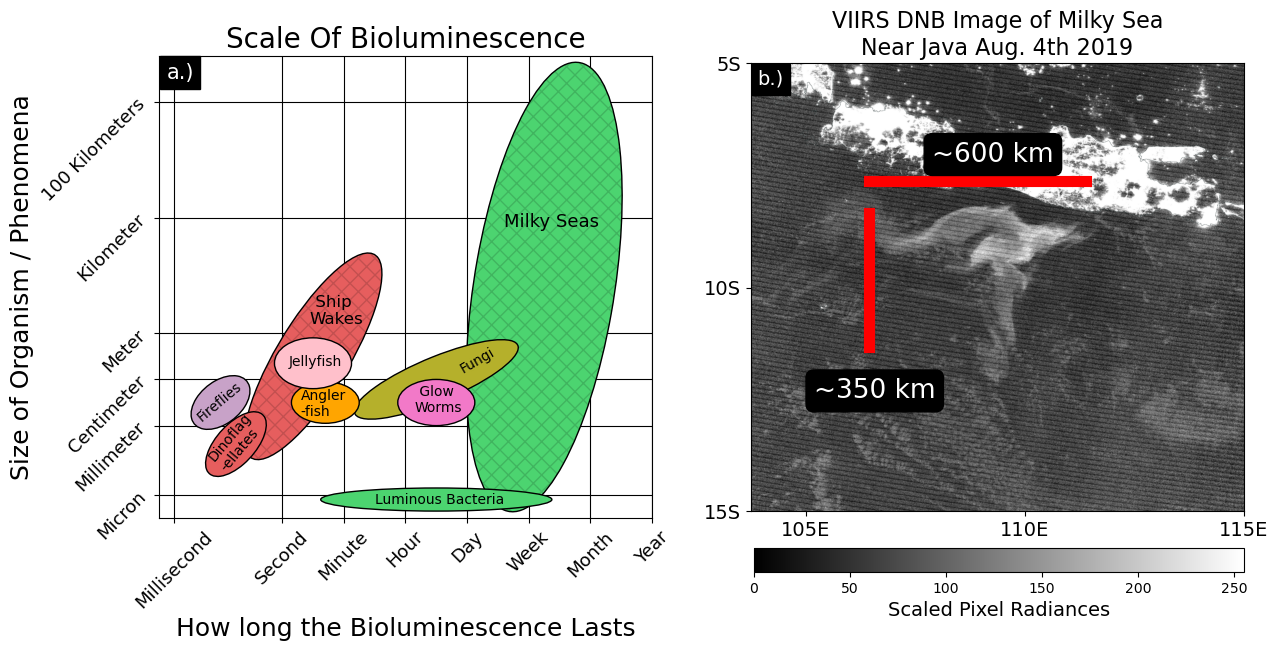

In [6]:
# load the image from NASA Worldview
wv_im = Image.open('./DATA/WORLDVIEW_AUG_4th_2019.png')
# make the figures/axes
fig,axs = plt.subplots(1,2,figsize = (14,6))
#start with the first subplot (scale of bioluminescence)
ax = axs[0]
ax.set_xticks([5,40,60,80,100,120,140,160],['Millisecond','Second','Minute','Hour','Day','Week','Month','Year'],rotation = 45,fontsize = 13)
ax.set_yticks([5,20,30,40,65,90],['Micron','Millimeter','Centimeter','Meter','Kilometer','100 Kilometers'],rotation = 45,fontsize = 13)
ax.set_xlim(0,160)
ax.set_ylim(0,100)
ax.grid(alpha = 1, zorder = 0, color = 'k')
# now add in the various biolum patches

#Milky Seas (1-100s of Kilometers in size, days to months)
# Miller et al. 2021
milky_sea_ellipse = patches.Ellipse((125,50),100,45,angle = 75, facecolor = '#4cd470',edgecolor = 'k', alpha = 1, zorder = 2)
ax.add_patch(milky_sea_ellipse)
milke_sea_hatch_ellipse = patches.Ellipse((125,50),100,45,angle = 75, alpha = 0.15,facecolor = 'None',linewidth = 0,edgecolor = 'k',zorder = 2,hatch = '\\\\//')
ax.add_patch(milke_sea_hatch_ellipse)
ax.text(112,63,"Milky Seas",rotation = 0, fontsize = 13, color = 'k')

#Anglerfish (~1 Meter in size, and lure is out for about a 20seconds - minute)
#Luck and Pietsch 2008, In-Situ Observations of a Deep-Sea Ceratioid Anglerfish of the Genus Oneirdes
anglerfish_patch = patches.Ellipse((54,25),22,9, angle = 0, zorder = 5, facecolor = 'orange',edgecolor = 'k')
ax.add_patch(anglerfish_patch)
ax.text(46,22,'Angler\n-fish',rotation = 0,zorder = 6)

#Fireflies (100-200 Milliseconds, on the order of 1-10 millimeters)
#Rabha et al. 2021, Light From a Firefly at Temperatures Considereably Higher and Lower Than Normal
firefly_patch = patches.Ellipse((20,25),20,10,angle = 20, facecolor = '#C8A2C8',edgecolor = 'k',zorder = 5)
ax.add_patch(firefly_patch)
ax.text(11.5,21,'Fireflies',rotation = 40, zorder = 5)

#Dinoflaggelates (100 Milliseconds per flash, they're about 30um to 1mm in size)
dinoflagelate_patch = patches.Ellipse((25,16),10,22,angle = -60,zorder=3,facecolor = '#e65e5e',edgecolor = 'k')
ax.add_patch(dinoflagelate_patch)
ax.text(15.2,10.2,'Dinoflag\n-ellates',rotation = 50)
#Ship Wakes for DFLAGS
ship_wake_patch = patches.Ellipse((50,35),60,20, facecolor = "#e65e5e", edgecolor = 'k',zorder = 2,angle = 45)
ship_wake_hatch_patch = patches.Ellipse((50,35),60,20,facecolor = "None",edgecolor = 'k',linewidth = 0,angle = 45,hatch = '\\\\//',zorder = 2,alpha = 0.15)
ax.add_patch(ship_wake_patch)
ax.add_patch(ship_wake_hatch_patch)
ax.text(49,42," Ship\nWakes", fontsize = 12)

# V. Harveyi (1 um in size, and they can glow for seconds-weeks to possibly more if conditions are right)
# Nealson and Hastings 1979
vharveyi_patch = patches.Ellipse((90,4),75,5,facecolor = '#4cd470',edgecolor = 'k',zorder = 2)
ax.add_patch(vharveyi_patch)
# vharveyi_hatch_patch = patches.Ellipse((90,4),75,5,facecolor = 'None',linewidth = 0,alpha = 0.3, edgecolor = 'k',hatch = '//',zorder = 2)
# ax.add_patch(vharveyi_hatch_patch)
ax.text(70,3,'Luminous Bacteria')

# Gloworms (mm-cm in lengths and they glow for an entire night so ~12 hours) 
# Merritt and Patterson, Environmental influences on the bioluminescence display of the glow-worm, Arachnocampa flava (Diptera: Keroplatidae)
glowworm_patch = patches.Ellipse((90,25),25,10, facecolor = '#f279c8',edgecolor = 'k', zorder=4)
ax.add_patch(glowworm_patch)
ax.text(83,23,' Glow\nWorms',zorder = 5)

# Fungi (mm - meter scales, and seconds - a few days
fungal_patch = patches.Ellipse((90,30),55,10,angle = 15, edgecolor = 'k',facecolor = '#b5b02b',zorder=3)
ax.add_patch(fungal_patch)
ax.text(97,31.5,'Fungi',rotation = 30)

# Jellyfish (cm - meter scales, ms - s?)
jellyfish_patch = patches.Ellipse((50,33.5),25,11,zorder = 6, facecolor = 'pink', edgecolor = 'k')
ax.add_patch(jellyfish_patch)
ax.text(42,33,'Jellyfish',zorder = 7)

#now add in the title and various labels
ax.set_title('Scale Of Bioluminescence', fontsize = 20)

ax.set_xlabel("How long the Bioluminescence Lasts",fontsize = 18)
ax.set_ylabel("Size of Organism / Phenomena", fontsize = 18)

props = dict(boxstyle='square', facecolor='k', alpha=1)
ax.text(2.4,95.1,'a.)',color = 'w',bbox = props,fontsize = 15)

#now do the second subplot, the image from NASA worldview

ax1 = axs[1]
ax1.set_xticks([139,695,1251],['105E','110E','115E'],fontsize = 14)
ax1.set_yticks([0,570,1137],['5S','10S','15S'],fontsize = 14)

im1 = ax1.imshow(wv_im,cmap = 'binary_r')

#put in the lines showing the scale of the feature
ax1.plot([300,300],[380,720],color = 'r',linewidth = 8)
props = dict(boxstyle='round', facecolor='k', alpha=1)
ax1.text(160,850,'~350 km',color = 'w',bbox=props,fontsize = 19)

ax1.plot([300,850],[300,300],color = 'r',linewidth = 8)
ax1.text(460,250,'~600 km',color = 'w',bbox=props,fontsize = 19)
props = dict(boxstyle='square', facecolor='k', alpha=1)

#put in the title/label for the subplot
ax1.text(17,55,'b.)',color = 'w',fontsize = 14,bbox = props)
ax1.set_title('VIIRS DNB Image of Milky Sea\nNear Java Aug. 4th 2019',fontsize = 16)

# add the colorbar for the image
cax = fig.add_axes([0.55, 0.02, 0.35, 0.04])
cb = fig.colorbar(im1, cax=cax, orientation='horizontal')
cb.set_label('Scaled Pixel Radiances',fontsize = 14)

#save the figure
#plt.savefig('./FIGURES/Figure_1.jpg',dpi = 350,bbox_inches = 'tight')
#display it
plt.show()

## Make Figure 2

In [7]:
# load the database
start_dates,start_hours,end_dates,end_hours,lats,lons,ships,observors,descriptions,reported,approx_locs,phenomena,confidence,area,ev_num = np.loadtxt(database_path,delimiter='\t',dtype = str,unpack = True,skiprows = 1)
# process the information from the file into the format I want
# get the dates
obs_start_dates,obs_end_dates = convert_dates(start_dates,end_dates)
# get the lat/lons
obs_lats = [get_loc_in_degrees(lat) for lat in lats]
obs_lons = [get_loc_in_degrees(lon) for lon in lons]
#get the year for every start date
obs_years = [osd.year for osd in obs_start_dates]

In [8]:
# loop over the data making a list of events
# set the max_dist and max_day thresholds
max_day = 90 #90 days
max_dist = 8 #8 degrees

# holds the Events
event_array = []
# tracks which observations have already been placed in events
event_coding = np.zeros(len(obs_start_dates))
for i in range(len(obs_start_dates)):
    if i == 0:
        new_ev = Event(obs_start_dates[i],obs_end_dates[i],obs_lats[i],obs_lons[i],confidence[i],area[i],max_day,max_dist)
        event_coding[i] = 1
        event_array.append(new_ev)
    else:
        if event_coding[i] == 0:
            new_ev = Event(obs_start_dates[i],obs_end_dates[i],obs_lats[i],obs_lons[i],confidence[i],area[i],max_day,max_dist)
            event_coding[i] = 1
            event_array.append(new_ev)
    for j in range(i+1,len(obs_start_dates)):
        if event_coding[j] == 0:
            if event_array[-1].consider_new_ob(obs_start_dates[j],obs_end_dates[j],obs_lats[j],obs_lons[j],confidence[j],area[j]):
                event_coding[j] = 1

In [9]:
len(event_array)

257

In [10]:
# get the temporal lengths of events with more than a single date
event_time_lengths = []
for i in range(len(event_array)):
    if len(event_array[i].dates) >= 2:
        event_time_lengths.append((event_array[i].dates[-1] - event_array[i].dates[0]).days)


In [11]:
# get event areas where applicable
calculated_areas = []
for i in range(len(event_array)):
    event_array[i].set_polygon_area()
    if event_array[i].area_type == 'Calculated' and event_array[i].area > 0:
        calculated_areas.append(event_array[i].area)

satellite_areas = []
for i in range(len(area)):
    if area[i] != 'N/A':
        satellite_areas.append(float(area[i]))

event_areas = calculated_areas[:] + satellite_areas[:]

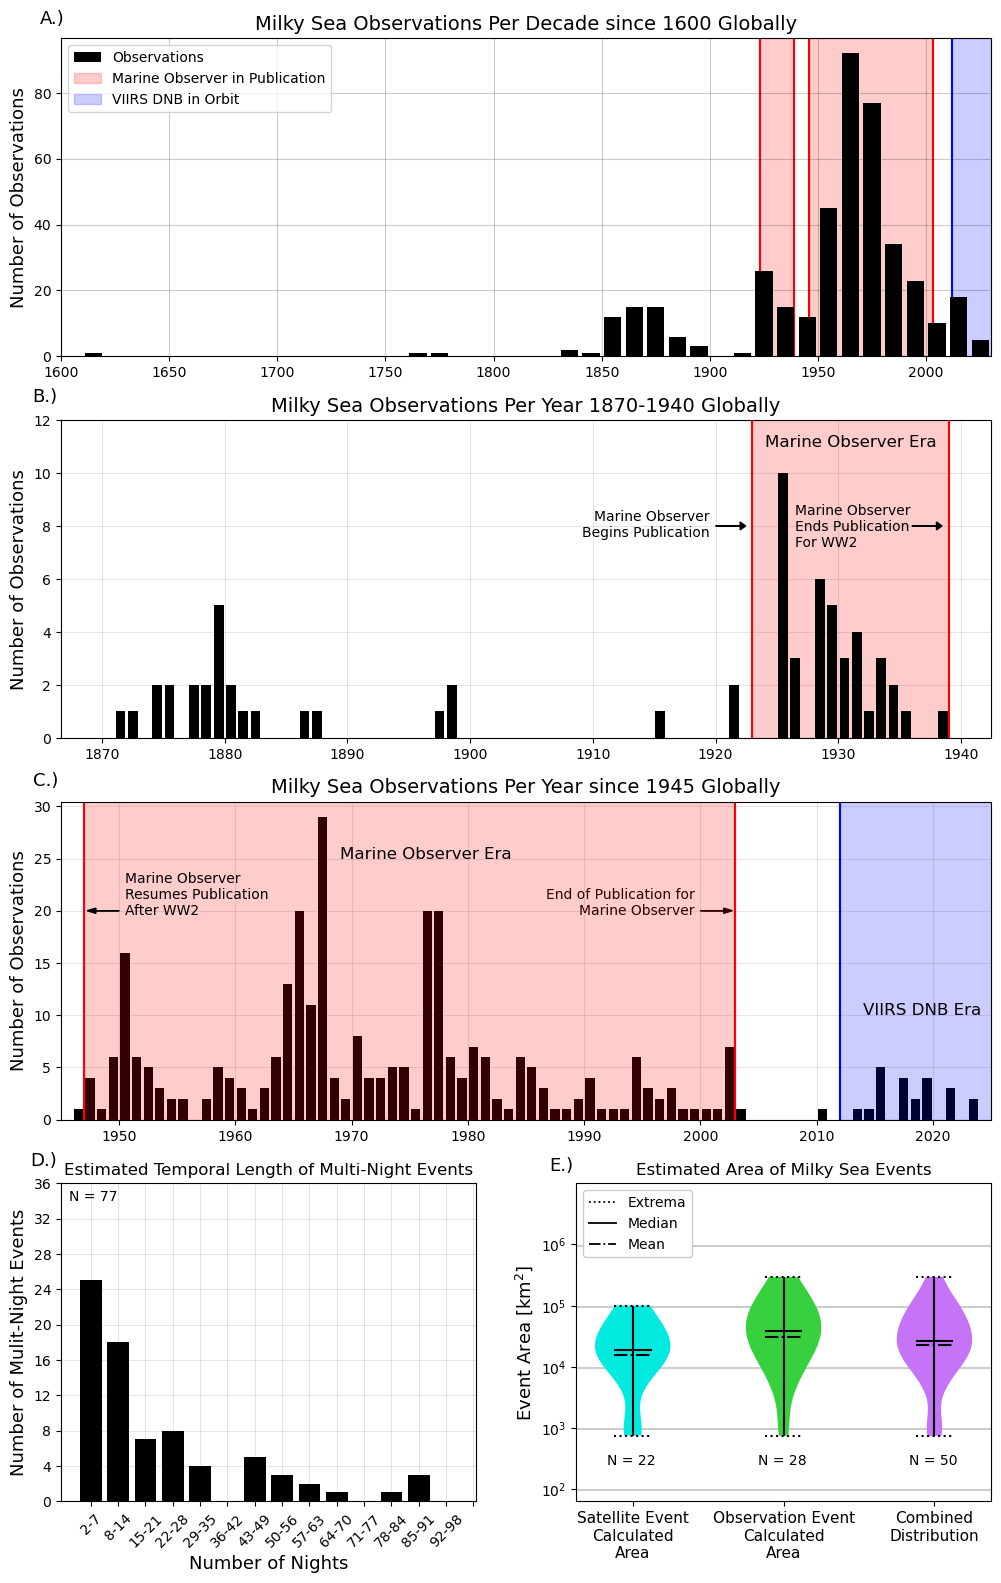

In [12]:
# Define the figure and divide it up using gridspec
fig = plt.figure(figsize = (12,19))
gs = gridspec.GridSpec(4, 11, width_ratios=[1,1,1,1,1,1,1,1,1,1,1])

# Axis 0 is for observations per decade
ax0 = plt.subplot(gs[0,:])
ax0.hist(obs_years,bins = np.arange(1600,2035,10),color = 'k',rwidth=0.8,zorder = 2,label = 'Observations')
ax0.set_title("Milky Sea Observations Per Decade since 1600 Globally",fontsize = 14)
ax0.set_ylabel("Number of Observations", fontsize = 13)
ax0.set_xticks([1600,1650,1700,1750,1800,1850,1900,1950,2000])
ax0.grid(zorder = 0,color = 'k',alpha = 0.2)
ax0.axvspan(1923,1939,color = 'r',alpha = 0.2,label = 'Marine Observer in Publication')
ax0.axvspan(1946,2003,color = 'r',alpha = 0.2)
ax0.axvspan(2012,2030,color = 'b',alpha = 0.2,label = 'VIIRS DNB in Orbit')
ax0.axvline(1923,color = 'r',zorder = 1)
ax0.axvline(1939,color = 'r',zorder = 1)
ax0.axvline(1946,color = 'r',zorder = 1)
ax0.axvline(2003,color = 'r',zorder = 1)
ax0.axvline(2012,color = 'b',zorder = 1)
ax0.set_xlim(1600,2030)
ax0.legend(loc = 'upper left')

# axis 1 is for observations per year 1870 - 1940
ax1 = plt.subplot(gs[1,:])
ax1.grid(zorder= 0,color = 'k',alpha = 0.1)
ax1.hist(obs_years,bins = np.arange(1870,1940,1),color = 'k',rwidth=0.8,zorder = 2)
ax1.set_title("Milky Sea Observations Per Year 1870-1940 Globally",fontsize = 14)
#ax[1].set_xlabel("Year")
ax1.set_ylabel("Number of Observations",fontsize = 13)
ax1.axvline(1923,color ='r',zorder = 3)
ax1.arrow(1920,8,2,0,head_width = 0.3,facecolor = 'k',zorder = 3)
ax1.text(1919.5,7.6,"Marine Observer\nBegins Publication",horizontalalignment = 'right',zorder = 3)
ax1.axvline(1939,color = 'r',zorder = 3)
ax1.arrow(1936,8,2,0,head_width = 0.3,facecolor = 'k',zorder = 3)
ax1.text(1926.5,7.2,"Marine Observer\nEnds Publication\nFor WW2",zorder = 3)
ax1.axvspan(1923,1939,color = 'r',alpha = 0.2,zorder = 1)
ax1.text(1924,11,'Marine Observer Era',fontsize = 12)
ax1.set_ylim(0,12)

# axis 2 is for observatiosn per year 1945 - 2024
ax2 = plt.subplot(gs[2,:])
ax2.grid(zorder = 0,color = 'k',alpha = 0.1)
ax2.hist(obs_years,bins = np.arange(1945,2028,1),color = 'k',rwidth=0.8,zorder = 2)
ax2.set_title("Milky Sea Observations Per Year since 1945 Globally",fontsize = 14)
ax2.set_ylabel("Number of Observations",fontsize = 13)
ax2.axvline(2003,color ='r',zorder = 2)
ax2.arrow(2000,20,2,0,head_width = 0.5,facecolor = 'k',zorder = 2)
ax2.text(1999.5,19.6,"End of Publication for\nMarine Observer",horizontalalignment = 'right',zorder = 2)
ax2.axvline(1947,color = 'r',zorder = 2)
ax2.axvspan(1947,2003,color = 'r',alpha = 0.2,zorder = 2)
ax2.arrow(1950,20,-2,0,head_width = 0.5,facecolor = 'k',zorder = 2)
ax2.text(1950.5,19.6,"Marine Observer\nResumes Publication\nAfter WW2",zorder = 2)
ax2.axvspan(2012,2030,color = 'b',alpha = 0.2,zorder = 2)
ax2.text(2014,10,"VIIRS DNB Era",zorder = 2,fontsize =12)
ax2.axvline(2012,color = 'b',zorder = 2)
ax2.set_xlim(1945,2025)
ax2.text(1969,25,'Marine Observer Era',fontsize = 12)

# axis 3 is the length of events in nights
ax3 = plt.subplot(gs[3,:5])
plot_ev_len = np.array(event_time_lengths)
plot_ev_len[np.where(plot_ev_len==1)] = -1
h3 = ax3.hist(plot_ev_len,np.arange(1,101,7),color = 'k',rwidth = 0.8)
ax3.set_title('Estimated Temporal Length of Multi-Night Events')
ax3.set_ylabel('Number of Mulit-Night Events',fontsize = 13)
ax3.set_xlabel('Number of Nights',fontsize = 13)
ax3.grid(zorder = 0,color = 'k',alpha = 0.1)
ax3.set_xticks(np.arange(1,101,7)+3.5,['2-7','8-14','15-21','22-28','29-35','36-42','43-49','50-56','57-63','64-70','71-77','78-84','85-91','92-98',''],rotation = 45)
ax3.set_yticks(np.arange(0,40,4))
ax3.text(-1,34,'N = 77')

# axis 4 is the area of events
ax4 = plt.subplot(gs[3,6:])
v4 = ax4.violinplot([np.log10(np.array(satellite_areas)),np.log10(np.array(calculated_areas)),np.log10(np.array(event_areas))],positions = [1,2,3],showmeans = True,showmedians=True)
ax4.set_xticks([1,2,3],['Satellite Event\nCalculated\nArea','Observation Event\nCalculated\nArea','Combined\nDistribution'],fontsize = 11)
ax4.set_yticks([2,3,4,5,6],['10$^2$','10$^3$','10$^4$','10$^5$','10$^6$'])
ax4.set_ylabel('Event Area [km$^2$]',fontsize = 13)
ax4.plot([],[],linestyle = ':',linewidth = 1.3,label = 'Extrema',color = 'k')
ax4.plot([],[],linewidth = 1.3,label = 'Median',color = 'k')
ax4.plot([],[],linewidth = 1.3,label = 'Mean',color = 'k',linestyle = '-.')
ax4.legend(loc = 'upper left',framealpha = 1)
ax4.set_ylim(1.8,7)
ax4.set_title('Estimated Area of Milky Sea Events')
ax4.text(0.83,2.4,f'N = {int(len(satellite_areas))}')
ax4.text(1.83,2.4,f'N = {int(len(calculated_areas))}')
ax4.text(2.83,2.4,f'N = {int(len(event_areas))}')
for i in range(2,7):
    ax4.axhline(i - 0.02,zorder = 1,color = 'k',alpha = 0.2)
# These are the settings for the violin plot on Axis 4
colors = ['#02E9E0', '#37D03F', '#C573F7']
# Set the color of the violin patches
for pc, color in zip(v4['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(1)

v4['bodies'][0].set_zorder(5)
v4['bodies'][1].set_zorder(5)
v4['bodies'][2].set_zorder(5)

# Set the linestyles
for partname in ('cbars','cmins','cmaxes','cmedians','cmeans'):
    v = v4[partname]
    v.set_edgecolor('k')
    v.set_linewidth(1.5)
    v.set_linestyle(':')
    v.set_zorder(6)

v4['cmedians'].set_edgecolor('k')
v4['cmedians'].set_linewidth(1.5)
v4['cmedians'].set_linestyle('-')

v4['cmeans'].set_edgecolor('k')
v4['cmeans'].set_linewidth(1.5)
v4['cmeans'].set_linestyle('-.')

v4['cbars'].set_linestyle('-')
v4['cbars'].set_linewidth(1.5)
v4['cbars'].set_alpha(1)

# Labels for the axes
ax0.text(1590,101,'A.)',fontsize = 13)
ax1.text(1864.3,12.7,'B.)',fontsize = 13)
ax2.text(1942.6,32,'C.)',fontsize = 13)
ax3.text(-11,38,'D.)',fontsize = 13)
ax4.text(0.45,7.2,'E.)',fontsize = 13)

plt.savefig('./FIGURES/Figure_2.jpg',dpi = 350,bbox_inches = 'tight')
plt.show()

## Make Figure 3

In [13]:
# define the marsden squares
square_collection = create_Marsden_Square_Collection()
# fill the marsden squares
fill_Marsden_Square_Collection(square_collection,obs_lats,obs_lons)

In [14]:
# make a grid to get the counts in each square
south_edges = np.arange(-90,90,15)
west_edges = np.arange(-180,180,15)
grid_counts = np.zeros((len(south_edges),len(west_edges)))

for square in square_collection:
    a = np.where(south_edges == square.south_edge)[0][0]
    b = np.where(west_edges == square.west_edge)[0][0]
    grid_counts[a,b] += square.num_points

    

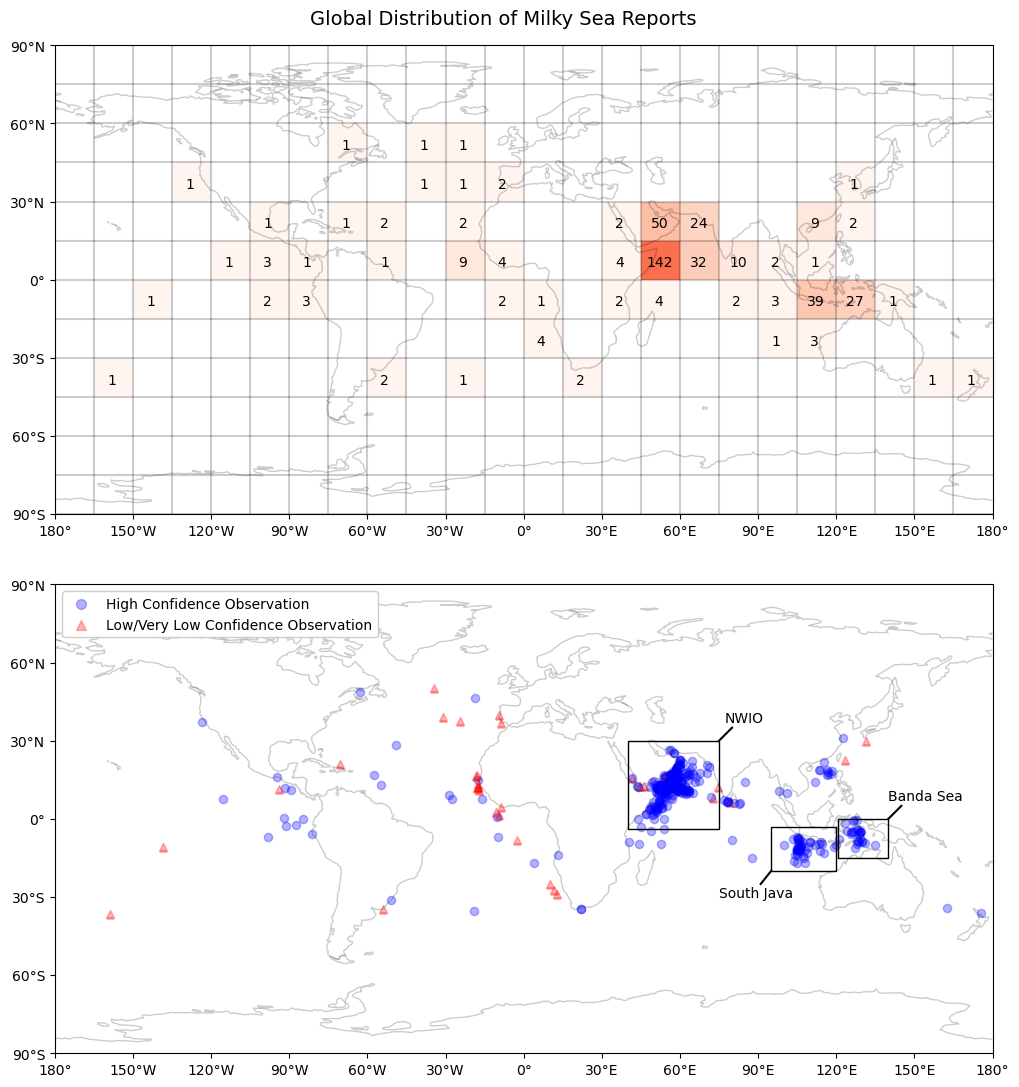

In [15]:
# make the figure
fig,ax = plt.subplots(2,1,figsize = (16,12),subplot_kw={'projection':ccrs.PlateCarree()})

# set up the background for both subplots
for item in ax:
    item.coastlines(color = 'k',alpha =0.2)
    item.set_global()
    item.set_xlim(-180,180)
    item.set_xticks([-180,-150,-120,-90,-60,-30,0,30,60,90,120,150,180],crs = ccrs.PlateCarree())
    item.set_yticks([-90,-60,-30,0,30,60,90],crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    item.xaxis.set_major_formatter(lon_formatter)
    item.yaxis.set_major_formatter(lat_formatter)

# Axis 0 are the counts per square
for edge in west_edges:
    ax[0].axvline(edge,color = 'k',alpha = 0.2)
for edge in south_edges:
    ax[0].axhline(edge,color = 'k',alpha = 0.2)

for square in square_collection:
    if square.num_points > 0 and square.num_points < 10:
        ax[0].text(square.west_edge+5,square.south_edge+5,str(square.num_points))
    if square.num_points >= 10 and square.num_points < 100:
        ax[0].text(square.west_edge+3.9,square.south_edge+5,str(square.num_points))
    if square.num_points > 100:
        ax[0].text(square.west_edge+2,square.south_edge+5,str(square.num_points))

# modify grid_counts so the colorbar looks nicer
filtered_grid_counts = np.copy(grid_counts)
filtered_grid_counts[np.where(grid_counts < 1)] = np.nan
filtered_grid_counts[np.where(grid_counts > 10)] += 20
filtered_grid_counts[np.where(grid_counts > 5)] += 20
ax[0].pcolormesh(west_edges + 7.5,south_edges+7.5,filtered_grid_counts,cmap = 'Reds',vmin = 0, vmax = 375)

# Axis 1 is the scatter plot
for i in range(len(confidence)):
    if int(confidence[i]) == 0:
        ax[1].scatter(obs_lons[i],obs_lats[i],s = 35,c='blue',alpha = 0.3,transform=ccrs.PlateCarree())
    else:
        ax[1].scatter(obs_lons[i],obs_lats[i],s = 35,c='red',alpha=0.3,transform=ccrs.PlateCarree(),marker = '^')

# Add rectangles for the hotspot boundaries
nwio_rect = Rectangle([40,-4],35,34,edgecolor = 'k',facecolor = None,fill = False)
ax[1].add_patch(nwio_rect)
ax[1].plot([75,80],[30,35],color = 'k')
ax[1].text(77,37,'NWIO')

java_rect = Rectangle([95,-20],25,17,edgecolor = 'k',facecolor = None, fill = False)
ax[1].add_patch(java_rect)
ax[1].plot([91,95],[-25,-20],color = 'k')
ax[1].text(75,-30,'South Java')

banda_rect = Rectangle([120.5,-15],19.5,15,edgecolor = 'k',facecolor = None,fill = False)
ax[1].add_patch(banda_rect)
ax[1].plot([140,145],[0,5],color = 'k')
ax[1].text(140,7,'Banda Sea')

ax[1].scatter([],[],s=50,c='blue',label = 'High Confidence Observation',alpha = 0.3)
ax[1].scatter([],[],s=50,color = 'r',label = 'Low/Very Low Confidence Observation',alpha = 0.3,marker = '^')

ax[1].legend(loc = 'upper left',facecolor='w',framealpha = 1)

plt.suptitle("Global Distribution of Milky Sea Reports",fontsize = 14)
plt.subplots_adjust(hspace = 0.15,top = 0.95)
plt.savefig('./FIGURES/Figure_3.jpg',dpi = 350,bbox_inches = 'tight')
plt.show()

## Make Figure 4

In [16]:
# get the months from the dates of the database
database_months = [od.month for od in obs_start_dates]
# count how many obs occurred each month
month_sums = [0,0,0,0,0,0,0,0,0,0,0,0]
for i in range(len(database_months)):
    month_sums[database_months[i]-1] += 1

# make the data needed to recreate the plot from Herring and Watson 1993
hw_months = []
add_month_sums(hw_months,1,27)
add_month_sums(hw_months,2,17)
add_month_sums(hw_months,3,1)
add_month_sums(hw_months,4,5)
add_month_sums(hw_months,5,1)
add_month_sums(hw_months,6,1)
add_month_sums(hw_months,7,35)
add_month_sums(hw_months,8,107)
add_month_sums(hw_months,9,30)
add_month_sums(hw_months,10,2)
add_month_sums(hw_months,11,1)
add_month_sums(hw_months,12,5)

hw_month_sums = [0,0,0,0,0,0,0,0,0,0,0,0]
for i in range(len(hw_months)):
    hw_month_sums[hw_months[i]-1] += 1


In [17]:
# determine which observations originated from Peter Herring's Records
record_inds = []
for i in range(len(reported)):
    if 'herring' in reported[i] or 'Herring' in reported[i]:
        record_inds.append(i)
    if 'Kay' in reported[i] or 'kay' in reported[i]:
        record_inds.append(i)
    if 'Barlow' in reported[i] or 'barlow' in reported[i]:
        record_inds.append(i)

# make a months list for these observations specifically
record_dates = np.array(obs_start_dates)[record_inds]
record_months = [rd.month for rd in record_dates]

record_month_sums = [0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in range(len(record_months)):
    if not np.isnan(record_months[i]):
        record_month_sums[record_months[i]-1] += 1

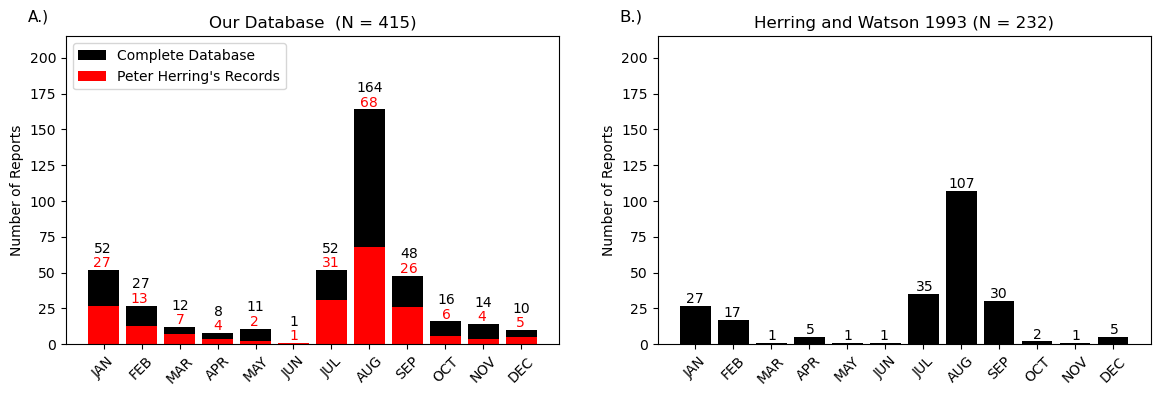

In [18]:
fig,ax = plt.subplots(1,2,figsize = (14,4))

ax[0].hist(database_months,bins = np.arange(0.5,13.5,1), color = 'k', rwidth = 0.8,zorder = 2,label = 'Complete Database')
ax[0].hist(record_months,bins = np.arange(0.5,13.5,1),color = 'r',rwidth = 0.8,zorder = 2, label = 'Peter Herring\'s Records')
ax[0].set_xticks(np.arange(1,13,1),['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'],rotation = 45)

ax[0].text(0.75,month_sums[0]+12,f'{month_sums[0]}',zorder = 12)
ax[0].text(1.75,month_sums[1]+12,f'{month_sums[1]}',zorder = 12)
ax[0].text(2.8,month_sums[2]+12,f'{month_sums[2]}',zorder = 12)
ax[0].text(3.9,month_sums[3]+12,f'{month_sums[3]}',zorder = 12)
ax[0].text(4.75,month_sums[4]+12,f'{month_sums[4]}',zorder = 12)
ax[0].text(5.9,month_sums[5]+12,f'{month_sums[5]}',zorder = 12)
ax[0].text(6.75,month_sums[6]+12,f'{month_sums[6]}',zorder = 12)
ax[0].text(7.65,month_sums[7]+12,f'{month_sums[7]}',zorder = 12)
ax[0].text(8.81,month_sums[8]+12,f'{month_sums[8]}',zorder = 12)
ax[0].text(9.8,month_sums[9]+12,f'{month_sums[9]}',zorder = 12)
ax[0].text(10.75,month_sums[10]+12,f'{month_sums[10]}',zorder = 12)
ax[0].text(11.75,month_sums[11]+12,f'{month_sums[11]}',zorder = 12)

ax[0].text(0.72,month_sums[0]+2,f'{record_month_sums[0]}',zorder = 12,color = 'r')
ax[0].text(1.7,month_sums[1]+2,f'{record_month_sums[1]}',zorder = 12,color = 'r')
ax[0].text(2.9,month_sums[2]+2,f'{record_month_sums[2]}',zorder = 12,color = 'r')
ax[0].text(3.9,month_sums[3]+2,f'{record_month_sums[3]}',zorder = 12,color = 'r')
ax[0].text(4.85,month_sums[4]+2,f'{record_month_sums[4]}',zorder = 12,color = 'r')
ax[0].text(5.9,month_sums[5]+2,f'{record_month_sums[5]}',zorder = 12,color = 'r')
ax[0].text(6.75,month_sums[6]+2,f'{record_month_sums[6]}',zorder = 12,color = 'r')
ax[0].text(7.75,month_sums[7]+2,f'{record_month_sums[7]}',zorder = 12,color = 'r')
ax[0].text(8.8,month_sums[8]+2,f'{record_month_sums[8]}',zorder = 12,color = 'r')
ax[0].text(9.9,month_sums[9]+2,f'{record_month_sums[9]}',zorder = 12,color = 'r')
ax[0].text(10.85,month_sums[10]+2,f'{record_month_sums[10]}',zorder = 12,color = 'r')
ax[0].text(11.85,month_sums[11]+2,f'{record_month_sums[11]}',zorder = 12,color = 'r')
ax[0].set_ylabel('Number of Reports')
ax[0].set_title(f'Our Database  (N = {len(obs_lats)})',fontsize = 12)

ax[0].set_ylim(0,215)
#plt.grid(zorder = 0,alpha = 0.4)
ax[0].legend(loc = 'upper left')

ax[1].hist(hw_months,bins = np.arange(0.5,13.5,1), color = 'k', rwidth = 0.8,zorder = 2)
ax[1].set_xticks(np.arange(1,13,1),['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'],rotation = 45)

ax[1].text(0.75,hw_month_sums[0]+2,f'{hw_month_sums[0]}',zorder = 12)
ax[1].text(1.75,hw_month_sums[1]+2,f'{hw_month_sums[1]}',zorder = 12)
ax[1].text(2.9,hw_month_sums[2]+2,f'{hw_month_sums[2]}',zorder = 12)
ax[1].text(3.9,hw_month_sums[3]+2,f'{hw_month_sums[3]}',zorder = 12)
ax[1].text(4.9,hw_month_sums[4]+2,f'{hw_month_sums[4]}',zorder = 12)
ax[1].text(5.85,hw_month_sums[5]+2,f'{hw_month_sums[5]}',zorder = 12)
ax[1].text(6.8,hw_month_sums[6]+2,f'{hw_month_sums[6]}',zorder = 12)
ax[1].text(7.65,hw_month_sums[7]+2,f'{hw_month_sums[7]}',zorder = 12)
ax[1].text(8.75,hw_month_sums[8]+2,f'{hw_month_sums[8]}',zorder = 12)
ax[1].text(9.9,hw_month_sums[9]+2,f'{hw_month_sums[9]}',zorder = 12)
ax[1].text(10.9,hw_month_sums[10]+2,f'{hw_month_sums[10]}',zorder = 12)
ax[1].text(11.9,hw_month_sums[11]+2,f'{hw_month_sums[11]}',zorder = 12)
ax[1].set_ylabel('Number of Reports')
ax[1].set_title(f'Herring and Watson 1993 (N = {len(hw_months)})',fontsize = 12)
ax[1].set_ylim(0,215)

ax[0].text(-1,225,'A.)',fontsize = 11)
ax[1].text(-1,225,'B.)',fontsize = 12)

plt.savefig('./FIGURES/Figure_4.jpg',dpi = 350,bbox_inches = 'tight')
plt.show()

## Figure 5

In [19]:
# Prepare the WSTMS data if it needs to be prepared
if not os.path.exists('./DATA/gsd_coarse.npy'):
    # this may take some time to run
    gsdc.reprocess_image_and_save(WSTMS_loadpath,WSTMS_savepath)

# load in the data
gsd_lats = np.load('./DATA/gsd_lats.npy')
gsd_lons = np.load('./DATA/gsd_lons.npy')
gsd_coarse = np.load('./DATA/gsd_coarse.npy')

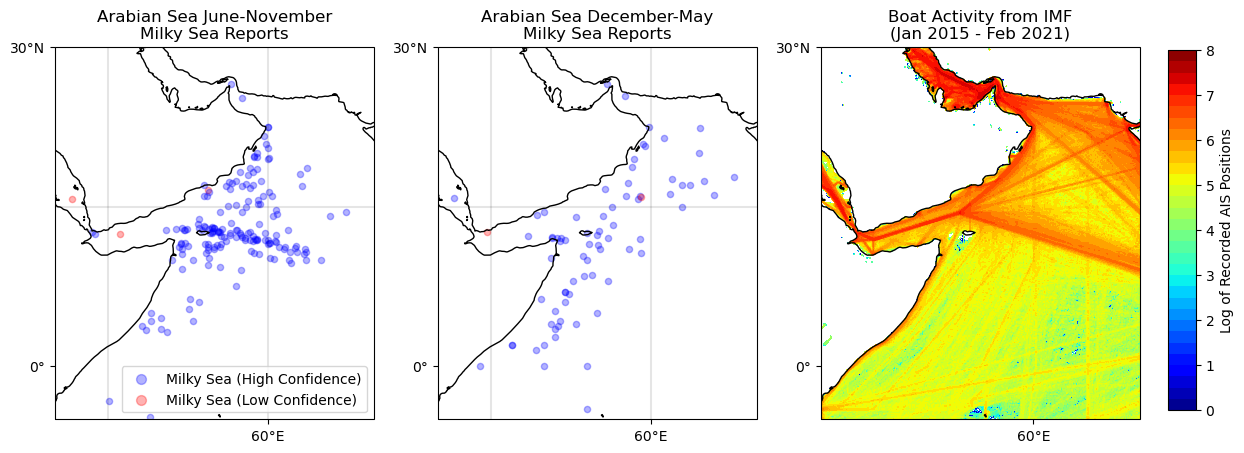

In [20]:
# make figure 4
# make the figure and subplots
fig,ax = plt.subplots(1,3,subplot_kw={'projection': ccrs.PlateCarree()},figsize = (14,6))

# add coastlines
ax[0].coastlines()
ax[1].coastlines()
ax[2].coastlines()

# subplot 1 is Boreal Summer eyewintess accounts
for i in range(len(confidence)):
    if obs_start_dates[i].month >= 6 and obs_start_dates[i].month <= 11:
        if int(confidence[i]) == 0:
            ax[0].scatter(obs_lons[i],obs_lats[i],s = 20,c='blue',alpha = 0.3,transform=ccrs.PlateCarree())
        else:
            ax[0].scatter(obs_lons[i],obs_lats[i],s = 20,c='red',alpha=0.3,transform=ccrs.PlateCarree())

# add in the legend
ax[0].scatter([],[],s=50,c='blue',label = 'Milky Sea (High Confidence)',alpha = 0.3)
ax[0].scatter([],[],s=50,color = 'r',label = 'Milky Sea (Low Confidence)',alpha = 0.3)
ax[0].legend(loc = 'best',facecolor='w')

# add the tick labels and title
ax[0].set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree())
ax[0].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax[0].xaxis.set_major_formatter(lon_formatter)
ax[0].yaxis.set_major_formatter(lat_formatter)
ax[0].set_title("Arabian Sea June-November\nMilky Sea Reports",fontsize = 12)


# subplot 2 is Boreal Winter eyewitness accounts
for i in range(len(confidence)):
    if obs_start_dates[i].month == 12 or obs_start_dates[i].month <= 5:
        if int(confidence[i]) == 0:
            ax[1].scatter(obs_lons[i],obs_lats[i],s = 20,c='blue',alpha = 0.3,transform=ccrs.PlateCarree())
        else:
            ax[1].scatter(obs_lons[i],obs_lats[i],s = 20,c='red',alpha=0.3,transform=ccrs.PlateCarree())

# add the tick labels and title
ax[1].set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree())
ax[1].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax[1].xaxis.set_major_formatter(lon_formatter)
ax[1].yaxis.set_major_formatter(lat_formatter)
ax[1].set_title("Arabian Sea December-May\nMilky Sea Reports",fontsize = 12)

# add in the shipping density data
cf1 = ax[2].contourf(gsd_lons,gsd_lats,gsd_coarse,levels = np.arange(0,8.25,0.25),cmap = 'jet')

# add the tick labels and title
ax[2].set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree())
ax[2].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax[2].xaxis.set_major_formatter(lon_formatter)
ax[2].yaxis.set_major_formatter(lat_formatter)
ax[2].set_title("Boat Activity from IMF\n(Jan 2015 - Feb 2021)",fontsize = 12)

# add the colorbar
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
plt.colorbar(cf1,cax = cax,orientation = 'vertical',label = 'Log of Recorded AIS Positions')

# add gridlines to subplots 1 and 2
for edge in np.arange(-180,180,15):
    ax[0].axvline(edge,color = 'k',alpha = 0.1)
    ax[1].axvline(edge,color = 'k',alpha = 0.1)
for edge in (-90,90,15):
    ax[0].axhline(edge,color = 'k',alpha = 0.1)
    ax[1].axhline(edge,color = 'k',alpha = 0.1)

# set the x and y limites for the plot
for item in ax:
    item.set_xlim(40,70)
    item.set_ylim(-5,30)

plt.savefig('./FIGURES/Figure_5.jpg',dpi = 350,bbox_inches = 'tight')

plt.show()


## Figure 6

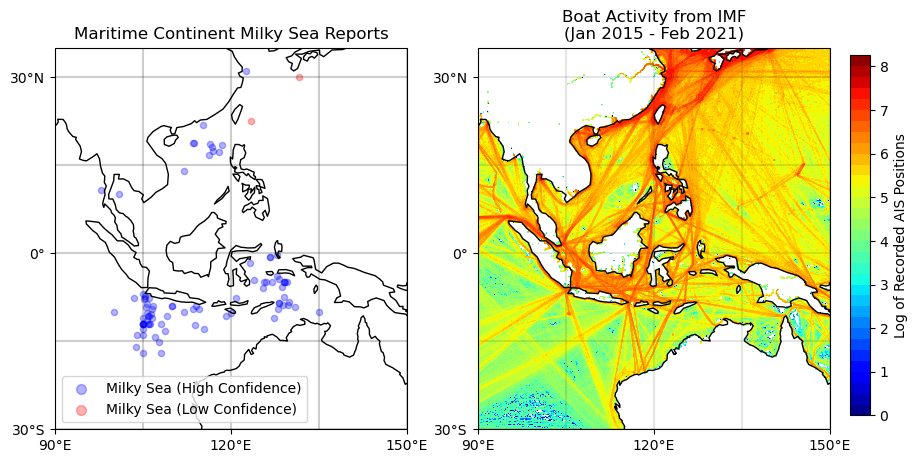

In [21]:
# make figure 6
# set up the figure and subplots
fig,ax = plt.subplots(1,2,subplot_kw={'projection': ccrs.PlateCarree()},figsize = (10,6))

# add coastlines
ax[0].coastlines()
ax[1].coastlines()

# add the Java/Banda Sea data points
for i in range(len(confidence)):
    if int(confidence[i]) == 0:
        ax[0].scatter(obs_lons[i],obs_lats[i],s = 20,c='blue',alpha = 0.3,transform=ccrs.PlateCarree())
    else:
        ax[0].scatter(obs_lons[i],obs_lats[i],s = 20,c='red',alpha=0.3,transform=ccrs.PlateCarree())

# add the legend
ax[0].scatter([],[],s=50,c='blue',label = 'Milky Sea (High Confidence)',alpha = 0.3)
ax[0].scatter([],[],s=50,color = 'r',label = 'Milky Sea (Low Confidence)',alpha = 0.3)
ax[0].legend(loc = 'best',facecolor='w')

# add grid lines
for edge in np.arange(-180,180,15):
    ax[0].axvline(edge,color = 'k',alpha = 0.1)
for edge in np.arange(-90,90,15):
    ax[0].axhline(edge,color = 'k',alpha = 0.1)

# add ticks and labels
ax[0].set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree())
ax[0].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax[0].xaxis.set_major_formatter(lon_formatter)
ax[0].yaxis.set_major_formatter(lat_formatter)
ax[0].set_title("Maritime Continent Milky Sea Reports",fontsize = 12)

# add the second subplot which is shipping density
cf1 = ax[1].contourf(gsd_lons,gsd_lats,gsd_coarse,levels = np.arange(0,8.5,0.25),cmap = 'jet')

# add the ticks and labels
ax[1].set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree())
ax[1].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax[1].xaxis.set_major_formatter(lon_formatter)
ax[1].yaxis.set_major_formatter(lat_formatter)
ax[1].set_title("Boat Activity from IMF\n(Jan 2015 - Feb 2021)",fontsize = 12)

# add the colorbar
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
plt.colorbar(cf1,cax = cax,orientation = 'vertical',label = 'Log of Recorded AIS Positions')

# add grid lines
for edge in np.arange(-180,180,15):
    ax[0].axvline(edge,color = 'k',alpha = 0.1)
    ax[1].axvline(edge,color = 'k',alpha = 0.1)
for edge in np.arange(-90,90,15):
    ax[0].axhline(edge,color = 'k',alpha = 0.1)
    ax[1].axhline(edge,color = 'k',alpha = 0.1)

# add the X and Y limites
for item in ax:
    item.set_xlim(90,150)
    item.set_ylim(-30,35)

plt.savefig('./FIGURES/Figure_6.jpg',dpi = 350,bbox_inches = 'tight')

plt.show()

## Figure 7

In [22]:
# define the boxes used to group the data
AS_BOX = [40,0,30,30]
JAVA_BOX = [90,-20,30,15]
BANDA_BOX = [120.5,-15,19.5,15]

# get the months and years from the dates
obs_months = [date.month for date in obs_start_dates]
obs_years = [date.year for date in obs_start_dates]

In [23]:
# put the data in the boxes
as_lats,as_lons,as_months,as_years = box_classify(AS_BOX,obs_lats,obs_lons,obs_months,obs_years)
java_lats,java_lons,java_months,java_years = box_classify(JAVA_BOX,obs_lats,obs_lons,obs_months,obs_years)
banda_lats,banda_lons,banda_months, banda_years = box_classify(BANDA_BOX,obs_lats,obs_lons,obs_months,obs_years)

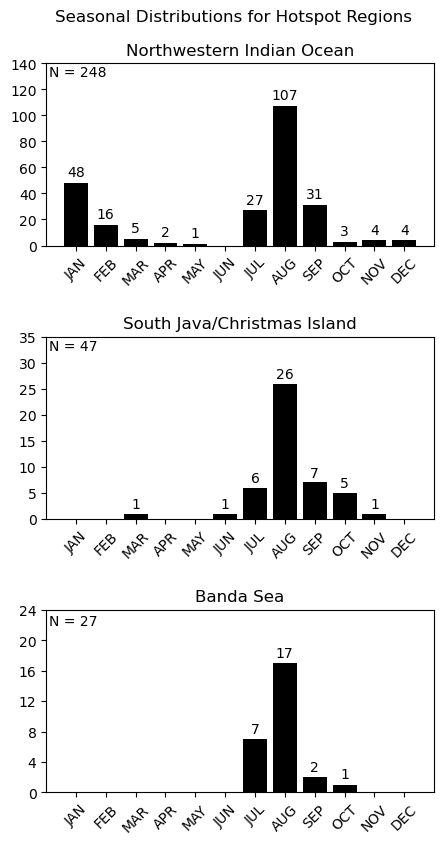

In [24]:
fig,ax = plt.subplots(3,1,figsize = (5,9))

h0 = ax[0].hist(as_months,bins = np.arange(0.5,13.5,1), color = 'k', rwidth = 0.8,zorder = 2)
ax[0].set_xticks(np.arange(1,13,1),['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'],rotation = 45)
ax[0].set_yticks(np.arange(0,160,20))

h2 = ax[2].hist(banda_months,bins = np.arange(0.5,13.5,1), color = 'k', rwidth = 0.8,zorder = 2)
ax[2].set_xticks(np.arange(1,13,1),['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'],rotation = 45)
ax[2].set_yticks(np.arange(0,28,4))

h1 = ax[1].hist(java_months,bins = np.arange(0.5,13.5,1), color = 'k', rwidth = 0.8,zorder = 2)
ax[1].set_xticks(np.arange(1,13,1),['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'],rotation = 45)
ax[1].set_yticks(np.arange(0,40,5))

ax[0].set_title("Northwestern Indian Ocean")
ax[2].set_title("Banda Sea")
ax[1].set_title("South Java/Christmas Island")

ax[0].text(0.1,130,f'N = {int(len(as_months))}')
ax[1].text(0.1,32.35,f'N = {int(len(java_months))}')
ax[2].text(0.1,22.,f'N = {int(len(banda_months))}')
# ax[1,1].set_title("South China Sea")
# ax[2,1].set_title("Central & South America")
# ax[2,0].set_title("Western and Southern Africa")

def add_hist_labels(ax:plt.axes,hist:plt.hist,y_adj:float) -> None:

    for i in range(len(hist[0])):
        if hist[0][i] >= 1 and hist[0][i] < 10:
            ax.text(hist[1][i]+0.35,hist[0][i]+y_adj,f'{int(hist[0][i])}')
        elif hist[0][i] >= 10 and hist[0][i] < 100:
            ax.text(hist[1][i]+0.2,hist[0][i]+y_adj,f'{int(hist[0][i])}')
        elif hist[0][i] >= 100:
            ax.text(hist[1][i]+0.05,hist[0][i]+y_adj,f'{int(hist[0][i])}')

    return None

add_hist_labels(ax[0],h0,5)
add_hist_labels(ax[1],h1,1)
add_hist_labels(ax[2],h2,0.8)

plt.suptitle("Seasonal Distributions for Hotspot Regions")

plt.subplots_adjust(hspace = 0.5,top = 0.92)
plt.savefig("./FIGURES/Figure_7.jpg",dpi = 350,bbox_inches = 'tight')
plt.show()

## Figure 8

In [25]:
# bring in the ERA5 1000 hPa winds for the Arabian Sea/NWIO
# after checking if they've already been downloaded
if not os.path.exists(ERA5_NWIO_1000hPa_Winds_path):
    print('Please run the Download_ERA5_Data.py script to download the data')
else:
    nwio_u,nwio_v,nwio_lats,nwio_lons = load_NWIO_1000hPa_winds()
    ocean_nwio_u,ocean_nwio_v = limit_NWIO_winds_to_ocean(nwio_u,nwio_v,nwio_lats,nwio_lons)
    nwio_env_total_winds = np.sqrt(ocean_nwio_u**2 + ocean_nwio_v**2)
    nwio_env_beaufort_winds = convert_mps_winds_to_beaufort(nwio_env_total_winds)


In [26]:
# bring in the HadISST SST data after checking if it has been downloaded
if not os.path.exists(HadISST_path):
    print('Please downlaod the HadISST SST data from:\nhttps://www.metoffice.gov.uk/hadobs/hadisst/data/download.html')
else:
    HadISST_ds = xr.open_dataset(HadISST_path)
    HadISST_NWIO_SST = HadISST_ds.sel(time=slice("1941-01-01", "2023-12-01"),latitude = slice(20,0),longitude = slice(40,60))['sst'].values


In [27]:
# Bring in the observations from the dataset
db_winds,db_temps = np.loadtxt('./DATA/Winds_and_Temps_From_Obs.csv',delimiter=',',skiprows=1,unpack=True,dtype=str)
# Convert from string to desired data type as well as handle the temperature units
conv_db_winds = [int(wind) for wind in db_winds]

def F_to_C(temp):
    return (temp - 32)*(5/9)

conv_db_temps = []
for i in range(len(db_temps)):
    if db_temps[i] != 'NAN' and db_temps[i] != '':
        if db_temps[i][-1] == 'F':
            conv_db_temps.append(F_to_C(float(db_temps[i][:-1])))
        else:
            conv_db_temps.append(float(db_temps[i][:-1]))

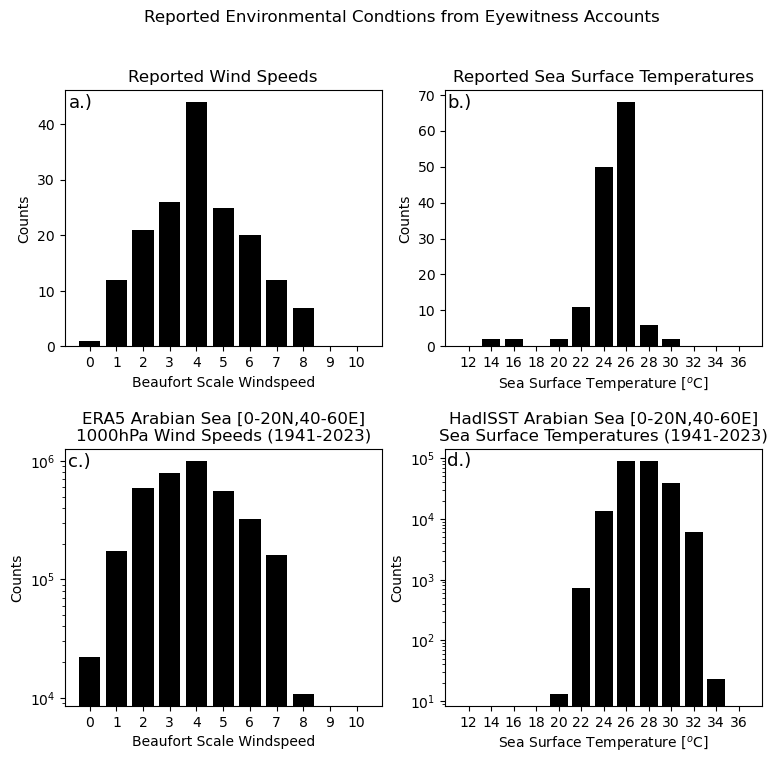

In [28]:
fig,ax = plt.subplots(2,2,figsize = (9,8))

ax[0,0].hist(conv_db_winds,bins = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5],rwidth = 0.8,color = 'k')
ax[0,0].set_xticks([0,1,2,3,4,5,6,7,8,9,10])
ax[0,0].set_ylabel('Counts')
ax[0,0].set_xlabel('Beaufort Scale Windspeed')
ax[0,0].set_title("Reported Wind Speeds")

ax[0,1].hist(conv_db_temps,bins = np.arange(11,39,2),rwidth = 0.8,color = 'k')
ax[0,1].set_xticks([12,14,16,18,20,22,24,26,28,30,32,34,36])
ax[0,1].set_ylabel('Counts')
ax[0,1].set_xlabel("Sea Surface Temperature [$^o$C]")
ax[0,1].set_title("Reported Sea Surface Temperatures")

ax[1,0].hist(nwio_env_beaufort_winds.flatten(),bins = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5],rwidth = 0.8,color = 'k')
ax[1,0].set_xticks([0,1,2,3,4,5,6,7,8,9,10])
ax[1,0].set_ylabel('Counts')
ax[1,0].set_xlabel('Beaufort Scale Windspeed')
ax[1,0].set_title("ERA5 Arabian Sea [0-20N,40-60E]\n1000hPa Wind Speeds (1941-2023)")
ax[1,0].set_yscale('log')

ax[1,1].hist(HadISST_NWIO_SST.flatten(),bins = np.arange(11,39,2),rwidth = 0.8,color = 'k')
ax[1,1].set_xticks([12,14,16,18,20,22,24,26,28,30,32,34,36])
ax[1,1].set_ylabel('Counts')
ax[1,1].set_xlabel('Sea Surface Temperature [$^o$C]')
ax[1,1].set_title('HadISST Arabian Sea [0-20N,40-60E]\nSea Surface Temperatures (1941-2023)')
ax[1,1].set_yscale('log')

ax[0,0].text(-0.8,43,'a.)',fontsize = 13)
ax[0,1].text(10.1,66.5,'b.)',fontsize = 13)
ax[1,0].text(-0.8,9e5,'c.)',fontsize = 13)
ax[1,1].text(10.1,7.5e4,'d.)',fontsize = 13)

plt.subplots_adjust(hspace=0.4)
plt.suptitle("Reported Environmental Condtions from Eyewitness Accounts")
plt.savefig('./FIGURES/Figure_8.jpg',dpi = 350,bbox_inches='tight')

plt.show()

## Bootstrapping to make Figures 9-12

In [29]:
# Check if the CC Corrected DMI data needs to be made
if not os.path.exists('./DATA/CC_CORRECTED_DMI.txt'):
    dcc.process_and_write_data()
else:
    print('DMI Data Found.')

DMI Data Found.


In [ ]:
# run the bootstrapping script
# NOTE: This takes a while to run for all 5,000 iterations (several hours)
# for a quicker run I suggest 100 iterations instead
num_iterations = 5000
num_iterations = 100 # Delete this line or comment it out if you want to run all 5,000 iterations
bs.bootstrap_loop(N = num_iterations)

100 percent done
Elapsed Time: 26720 Seconds


In [31]:
# load in the bootstrapping data
#load the files in
el_nino_codes = np.load('./DATA/el_nino_codes.npy')
neutral_codes = np.load('./DATA/neutral_enso_codes.npy')
la_nina_codes = np.load('./DATA/la_nina_codes.npy')

eoy_el_nino_codes = np.load('./DATA/eoy_el_nino_codes.npy')
eoy_neutral_codes = np.load('./DATA/eoy_neutral_enso_codes.npy')
eoy_la_nina_codes = np.load('./DATA/eoy_la_nina_codes.npy')

pos_iod_codes = np.load('./DATA/pos_iod_codes.npy')
neu_iod_codes = np.load('./DATA/neu_iod_codes.npy')
neg_iod_codes = np.load('./DATA/neg_iod_codes.npy')

str_sw_codes = np.load('./DATA/str_sw_monsoon_codes.npy')
ave_sw_codes = np.load('./DATA/ave_sw_monsoon_codes.npy')
weak_sw_codes = np.load('./DATA/weak_sw_monsoon_codes.npy')

str_ne_codes = np.load('./DATA/str_ne_monsoon_codes.npy')
ave_ne_codes = np.load('./DATA/ave_ne_monsoon_codes.npy')
weak_ne_codes = np.load('./DATA/weak_ne_monsoon_codes.npy')

str_se_codes = np.load('./DATA/str_se_monsoon_codes.npy')
ave_se_codes = np.load('./DATA/ave_se_monsoon_codes.npy')
weak_se_codes = np.load('./DATA/weak_se_monsoon_codes.npy')

In [32]:
# set up some settings for the figures
day_distances = np.array([2,3,4,5,7,10,15,20,30,40,50,60,70,80,90])
deg_distances = np.array([0.25,0.5,0.75,1,1.5,2,3,4,5,6,7,8])

custom_cmap = (mpl.colors.ListedColormap([(0,0,0.7),(0.2,0.2,1),(0.5,0.5,1),(0.8,0.8,1),
                                          (.6,.6,.6),
                                          (1,0.8,0.8),(1,0.5,0.5),(1,0.2,0.2),(0.7,0,0)],N = 9))

## Figure 9

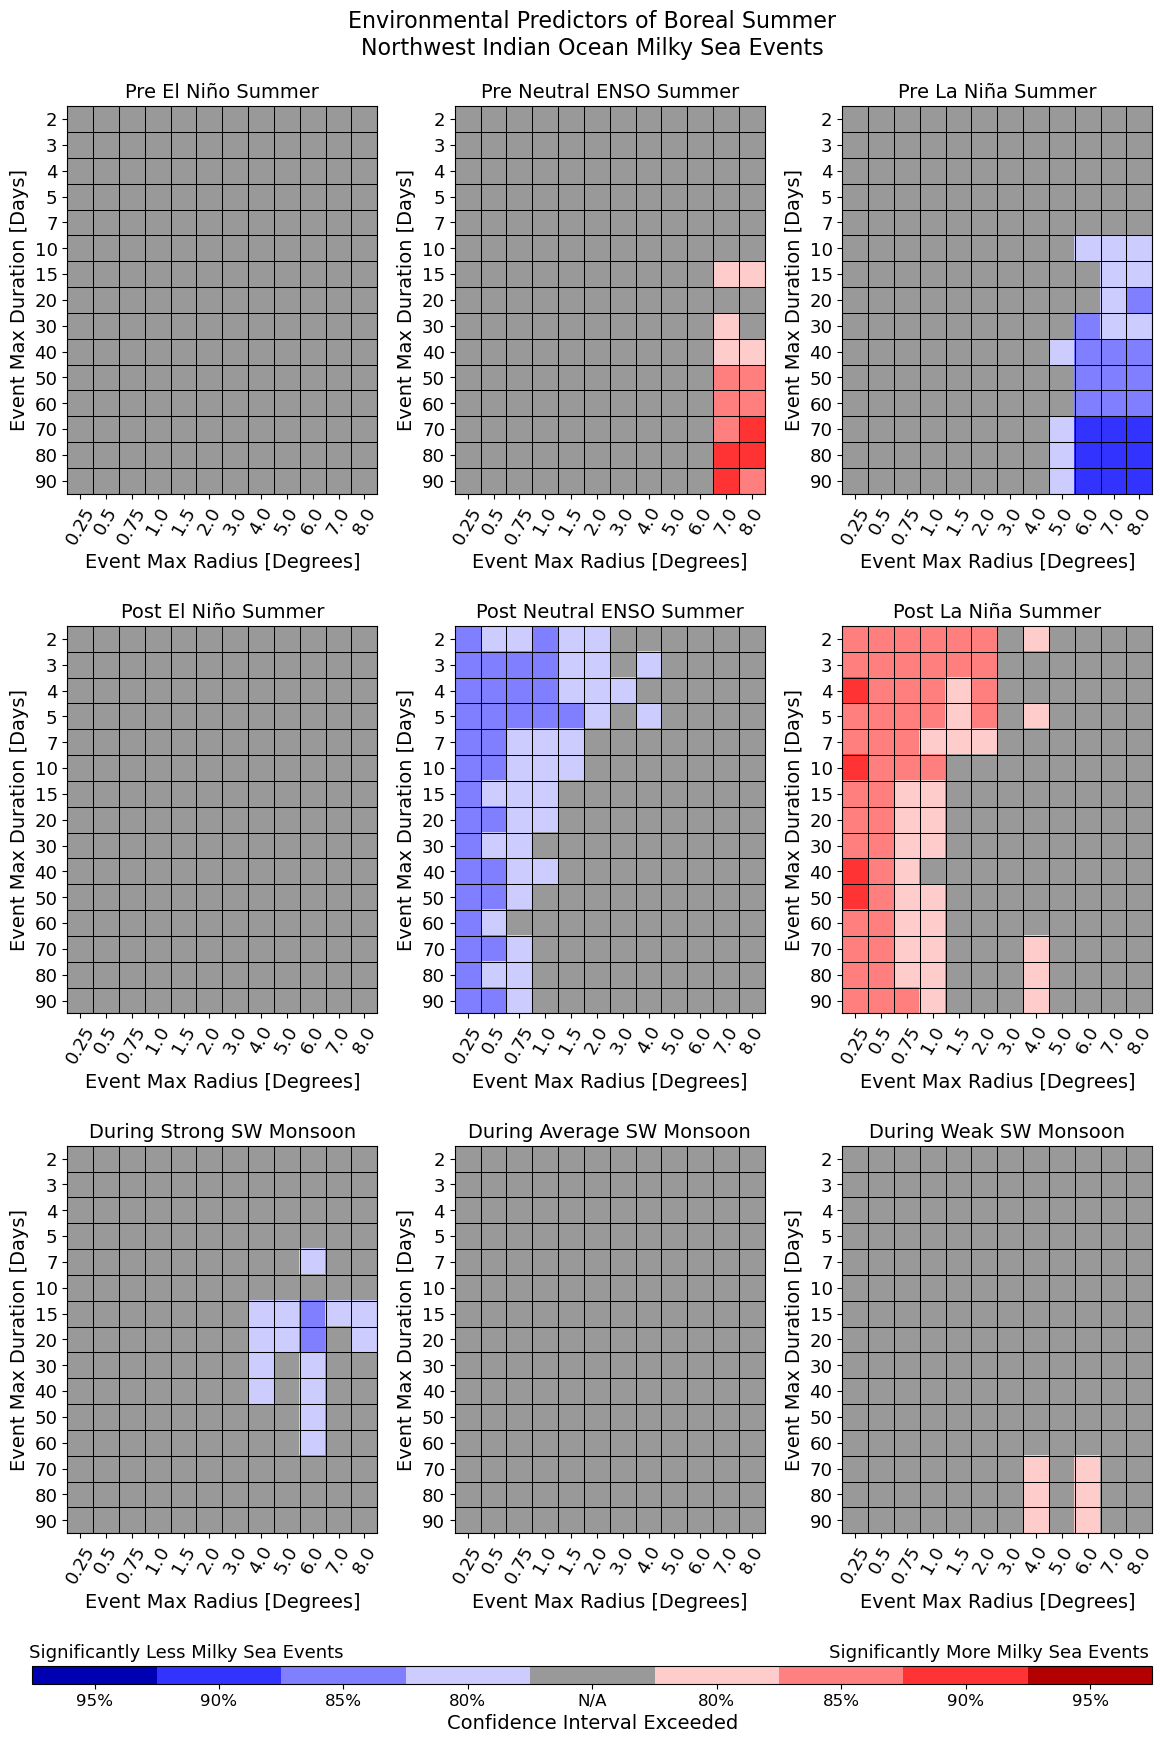

In [33]:
# now that I have the plot skeleton let's make one for Boreal Summer Arabian Sea Events
fig,ax = plt.subplots(3,3,figsize = (14,18))

#Fill in the images
im00 = ax[0,0].imshow(eoy_el_nino_codes[0],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im01 = ax[0,1].imshow(eoy_neutral_codes[0],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im02 = ax[0,2].imshow(eoy_la_nina_codes[0],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im10 = ax[1,0].imshow(el_nino_codes[0],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im11 = ax[1,1].imshow(neutral_codes[0],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im12 = ax[1,2].imshow(la_nina_codes[0],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im20 = ax[2,0].imshow(str_sw_codes[0],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im21 = ax[2,1].imshow(ave_sw_codes[0],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im22 = ax[2,2].imshow(weak_sw_codes[0],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')

#loop over the axes to add in details
for row in ax:
    for item in row:
        item.set_yticks(np.arange(0,len(day_distances)),day_distances,fontsize = 13)
        item.set_xticks(np.arange(0,len(deg_distances)),deg_distances,rotation = 60,fontsize = 13)
        item.set_ylabel("Event Max Duration [Days]",fontsize = 14)
        item.set_xlabel("Event Max Radius [Degrees]",fontsize = 14)
        for j in range(len(deg_distances)):
            item.axvline(j+0.5,color = 'k',linewidth = 0.75)
        for j in range(len(day_distances)):
            item.axhline(j+0.5,color = 'k',linewidth = 0.75)

#set up the colorbar axis
cax = fig.add_axes([0.1, 0.05, 0.8, 0.01]) #left bottom width height
cb = plt.colorbar(im00,cax=cax,ticks = [-4,-3,-2,-1,0,1,2,3,4],orientation = 'horizontal')
cb.set_ticklabels(['95%','90%','85%','80%','N/A','80%','85%','90%','95%'],fontsize = 12)
cb.set_label('Confidence Interval Exceeded',fontsize = 14)
#add in the titles for each axis
ax[0,0].set_title("Pre El Niño Summer",fontsize = 14)
ax[0,1].set_title("Pre Neutral ENSO Summer",fontsize = 14)
ax[0,2].set_title("Pre La Niña Summer",fontsize = 14)
ax[1,0].set_title("Post El Niño Summer",fontsize = 14)
ax[1,1].set_title("Post Neutral ENSO Summer",fontsize = 14)
ax[1,2].set_title("Post La Niña Summer",fontsize = 14)
ax[2,0].set_title("During Strong SW Monsoon",fontsize = 14)
ax[2,1].set_title("During Average SW Monsoon",fontsize = 14)
ax[2,2].set_title("During Weak SW Monsoon",fontsize = 14)
#add in some explanatory text
ax[2,1].text(-17,19.3,'Significantly Less Milky Sea Events',fontsize = 13)
ax[2,1].text(14,19.3,'Significantly More Milky Sea Events',fontsize = 13)

plt.suptitle("Environmental Predictors of Boreal Summer\nNorthwest Indian Ocean Milky Sea Events",fontsize = 16)

plt.subplots_adjust(wspace = 0.25,top = 0.95,hspace = 0.1)
plt.savefig("./FIGURES/Figure_9.jpg",dpi = 350,bbox_inches = 'tight')
plt.show()


## Figure 10

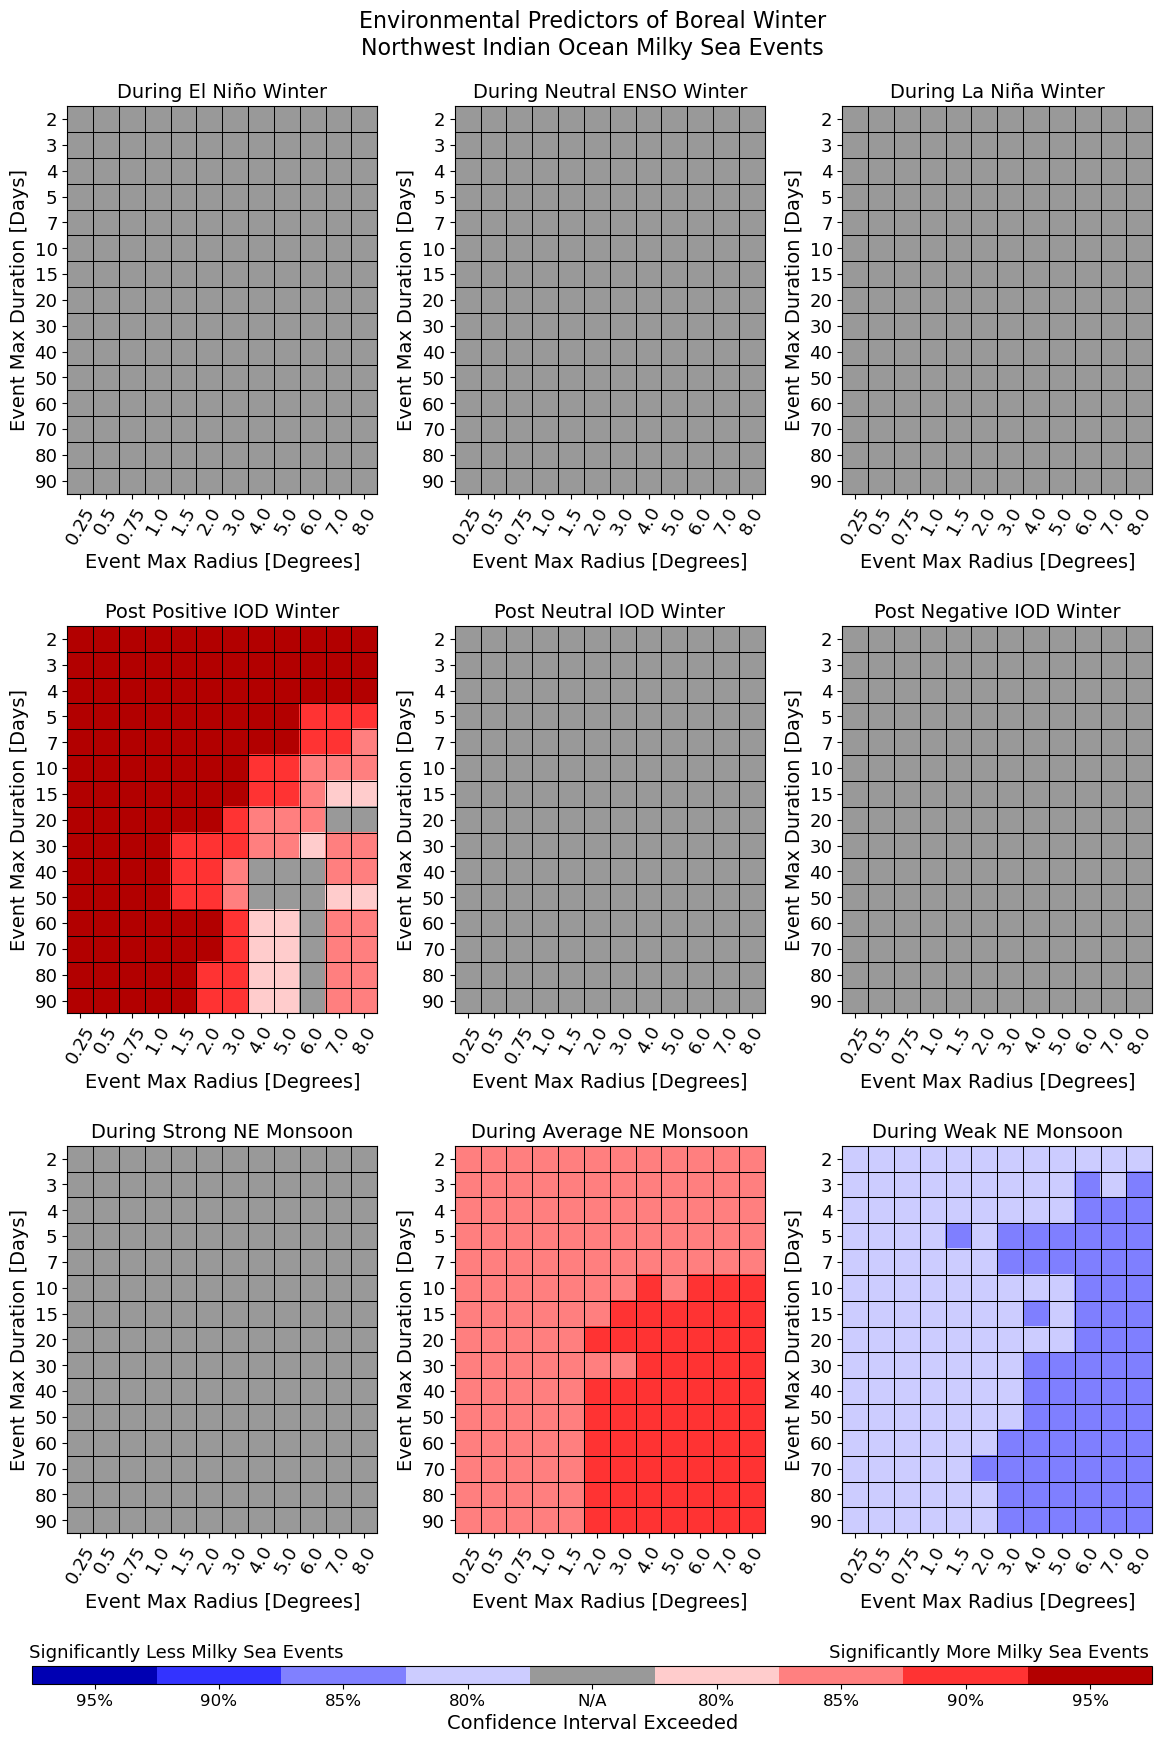

In [34]:
# now that I have the plot skeleton let's make one for Boreal Summer Arabian Sea Events
fig,ax = plt.subplots(3,3,figsize = (14,18))

#Fill in the images
im00 = ax[0,0].imshow(el_nino_codes[1],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im01 = ax[0,1].imshow(neutral_codes[1],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im02 = ax[0,2].imshow(la_nina_codes[1],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im10 = ax[1,0].imshow(pos_iod_codes[1],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im11 = ax[1,1].imshow(neu_iod_codes[1],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im12 = ax[1,2].imshow(neg_iod_codes[1],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im20 = ax[2,0].imshow(str_ne_codes[1],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im21 = ax[2,1].imshow(ave_ne_codes[1],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im22 = ax[2,2].imshow(weak_ne_codes[1],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')

#loop over the axes to add in details
for row in ax:
    for item in row:
        item.set_yticks(np.arange(0,len(day_distances)),day_distances,fontsize = 13)
        item.set_xticks(np.arange(0,len(deg_distances)),deg_distances,rotation = 60,fontsize = 13)
        item.set_ylabel("Event Max Duration [Days]",fontsize = 14)
        item.set_xlabel("Event Max Radius [Degrees]",fontsize = 14)
        for j in range(len(deg_distances)):
            item.axvline(j+0.5,color = 'k',linewidth = 0.75)
        for j in range(len(day_distances)):
            item.axhline(j+0.5,color = 'k',linewidth = 0.75)

#set up the colorbar axis
cax = fig.add_axes([0.1, 0.05, 0.8, 0.01]) #left bottom width height
cb = plt.colorbar(im00,cax=cax,ticks = [-4,-3,-2,-1,0,1,2,3,4],orientation = 'horizontal')
cb.set_ticklabels(['95%','90%','85%','80%','N/A','80%','85%','90%','95%'],fontsize = 12)
cb.set_label('Confidence Interval Exceeded',fontsize = 14)
#add in the titles for each axis
ax[0,0].set_title("During El Niño Winter",fontsize = 14)
ax[0,1].set_title("During Neutral ENSO Winter",fontsize = 14)
ax[0,2].set_title("During La Niña Winter",fontsize = 14)
ax[1,0].set_title("Post Positive IOD Winter",fontsize = 14)
ax[1,1].set_title("Post Neutral IOD Winter",fontsize = 14)
ax[1,2].set_title("Post Negative IOD Winter",fontsize = 14)
ax[2,0].set_title("During Strong NE Monsoon",fontsize = 14)
ax[2,1].set_title("During Average NE Monsoon",fontsize = 14)
ax[2,2].set_title("During Weak NE Monsoon",fontsize = 14)
#add in some explanatory text
ax[2,1].text(-17,19.3,'Significantly Less Milky Sea Events',fontsize = 13)
ax[2,1].text(14,19.3,'Significantly More Milky Sea Events',fontsize = 13)

plt.suptitle("Environmental Predictors of Boreal Winter\nNorthwest Indian Ocean Milky Sea Events",fontsize = 16)

plt.subplots_adjust(wspace = 0.25,top = 0.95,hspace = 0.1)
plt.savefig("./FIGURES/Figure_10.jpg",dpi = 350,bbox_inches = 'tight')
plt.show()


## Figure 11

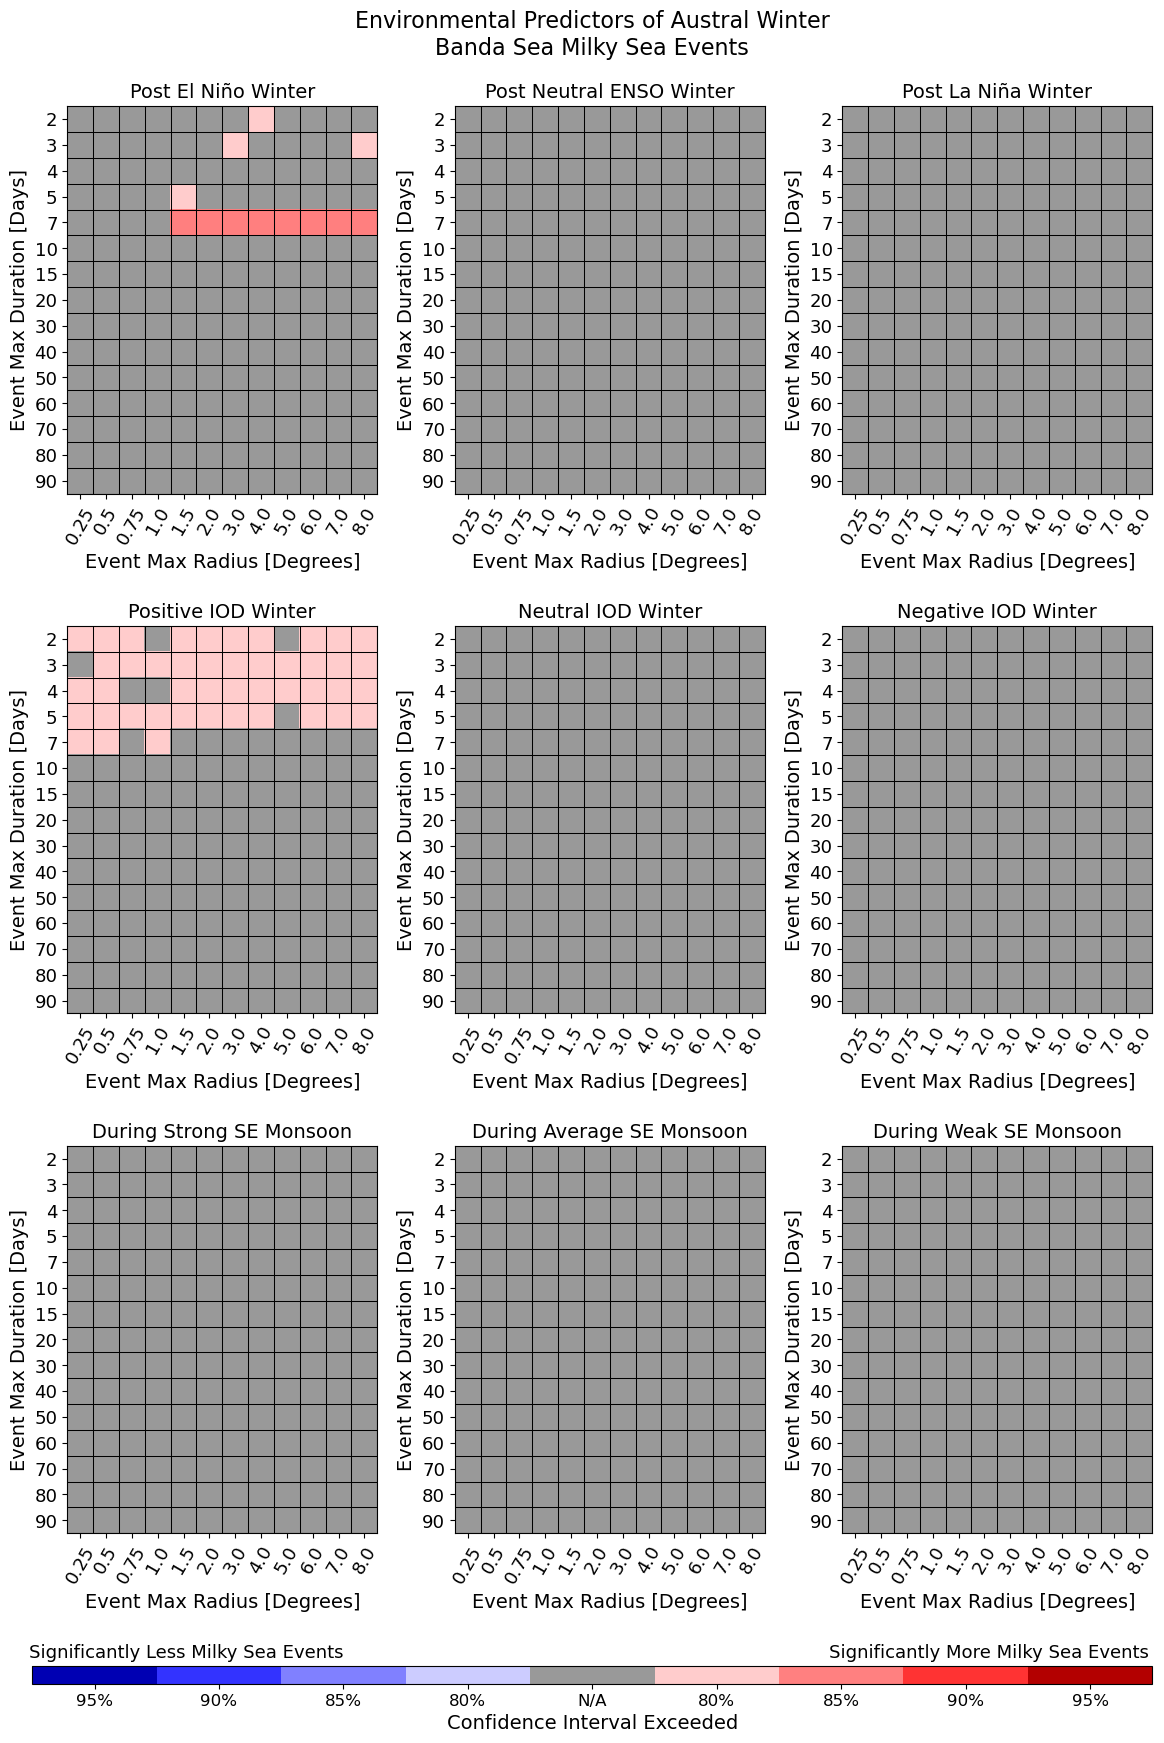

In [35]:
# now that I have the plot skeleton let's make one for Boreal Summer Arabian Sea Events
fig,ax = plt.subplots(3,3,figsize = (14,18))

#Fill in the images
im00 = ax[0,0].imshow(eoy_el_nino_codes[2],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im01 = ax[0,1].imshow(eoy_neutral_codes[2],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im02 = ax[0,2].imshow(eoy_la_nina_codes[2],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im10 = ax[1,0].imshow(pos_iod_codes[2],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im11 = ax[1,1].imshow(neu_iod_codes[2],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im12 = ax[1,2].imshow(neg_iod_codes[2],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im20 = ax[2,0].imshow(str_ne_codes[2],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im21 = ax[2,1].imshow(ave_ne_codes[2],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im22 = ax[2,2].imshow(weak_ne_codes[2],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')

#loop over the axes to add in details
for row in ax:
    for item in row:
        item.set_yticks(np.arange(0,len(day_distances)),day_distances,fontsize = 13)
        item.set_xticks(np.arange(0,len(deg_distances)),deg_distances,rotation = 60,fontsize = 13)
        item.set_ylabel("Event Max Duration [Days]",fontsize = 14)
        item.set_xlabel("Event Max Radius [Degrees]",fontsize = 14)
        for j in range(len(deg_distances)):
            item.axvline(j+0.5,color = 'k',linewidth = 0.75)
        for j in range(len(day_distances)):
            item.axhline(j+0.5,color = 'k',linewidth = 0.75)

#set up the colorbar axis
cax = fig.add_axes([0.1, 0.05, 0.8, 0.01]) #left bottom width height
cb = plt.colorbar(im00,cax=cax,ticks = [-4,-3,-2,-1,0,1,2,3,4],orientation = 'horizontal')
cb.set_ticklabels(['95%','90%','85%','80%','N/A','80%','85%','90%','95%'],fontsize = 12)
cb.set_label('Confidence Interval Exceeded',fontsize = 14)
#add in the titles for each axis
ax[0,0].set_title("Post El Niño Winter",fontsize = 14)
ax[0,1].set_title("Post Neutral ENSO Winter",fontsize = 14)
ax[0,2].set_title("Post La Niña Winter",fontsize = 14)
ax[1,0].set_title("Positive IOD Winter",fontsize = 14)
ax[1,1].set_title("Neutral IOD Winter",fontsize = 14)
ax[1,2].set_title("Negative IOD Winter",fontsize = 14)
ax[2,0].set_title("During Strong SE Monsoon",fontsize = 14)
ax[2,1].set_title("During Average SE Monsoon",fontsize = 14)
ax[2,2].set_title("During Weak SE Monsoon",fontsize = 14)
#add in some explanatory text
ax[2,1].text(-17,19.3,'Significantly Less Milky Sea Events',fontsize = 13)
ax[2,1].text(14,19.3,'Significantly More Milky Sea Events',fontsize = 13)

plt.suptitle("Environmental Predictors of Austral Winter\nBanda Sea Milky Sea Events",fontsize = 16)

plt.subplots_adjust(wspace = 0.25,top = 0.95,hspace = 0.1)
plt.savefig("./FIGURES/Figure_11.jpg",dpi = 350,bbox_inches = 'tight')
plt.show()


## Figure 12

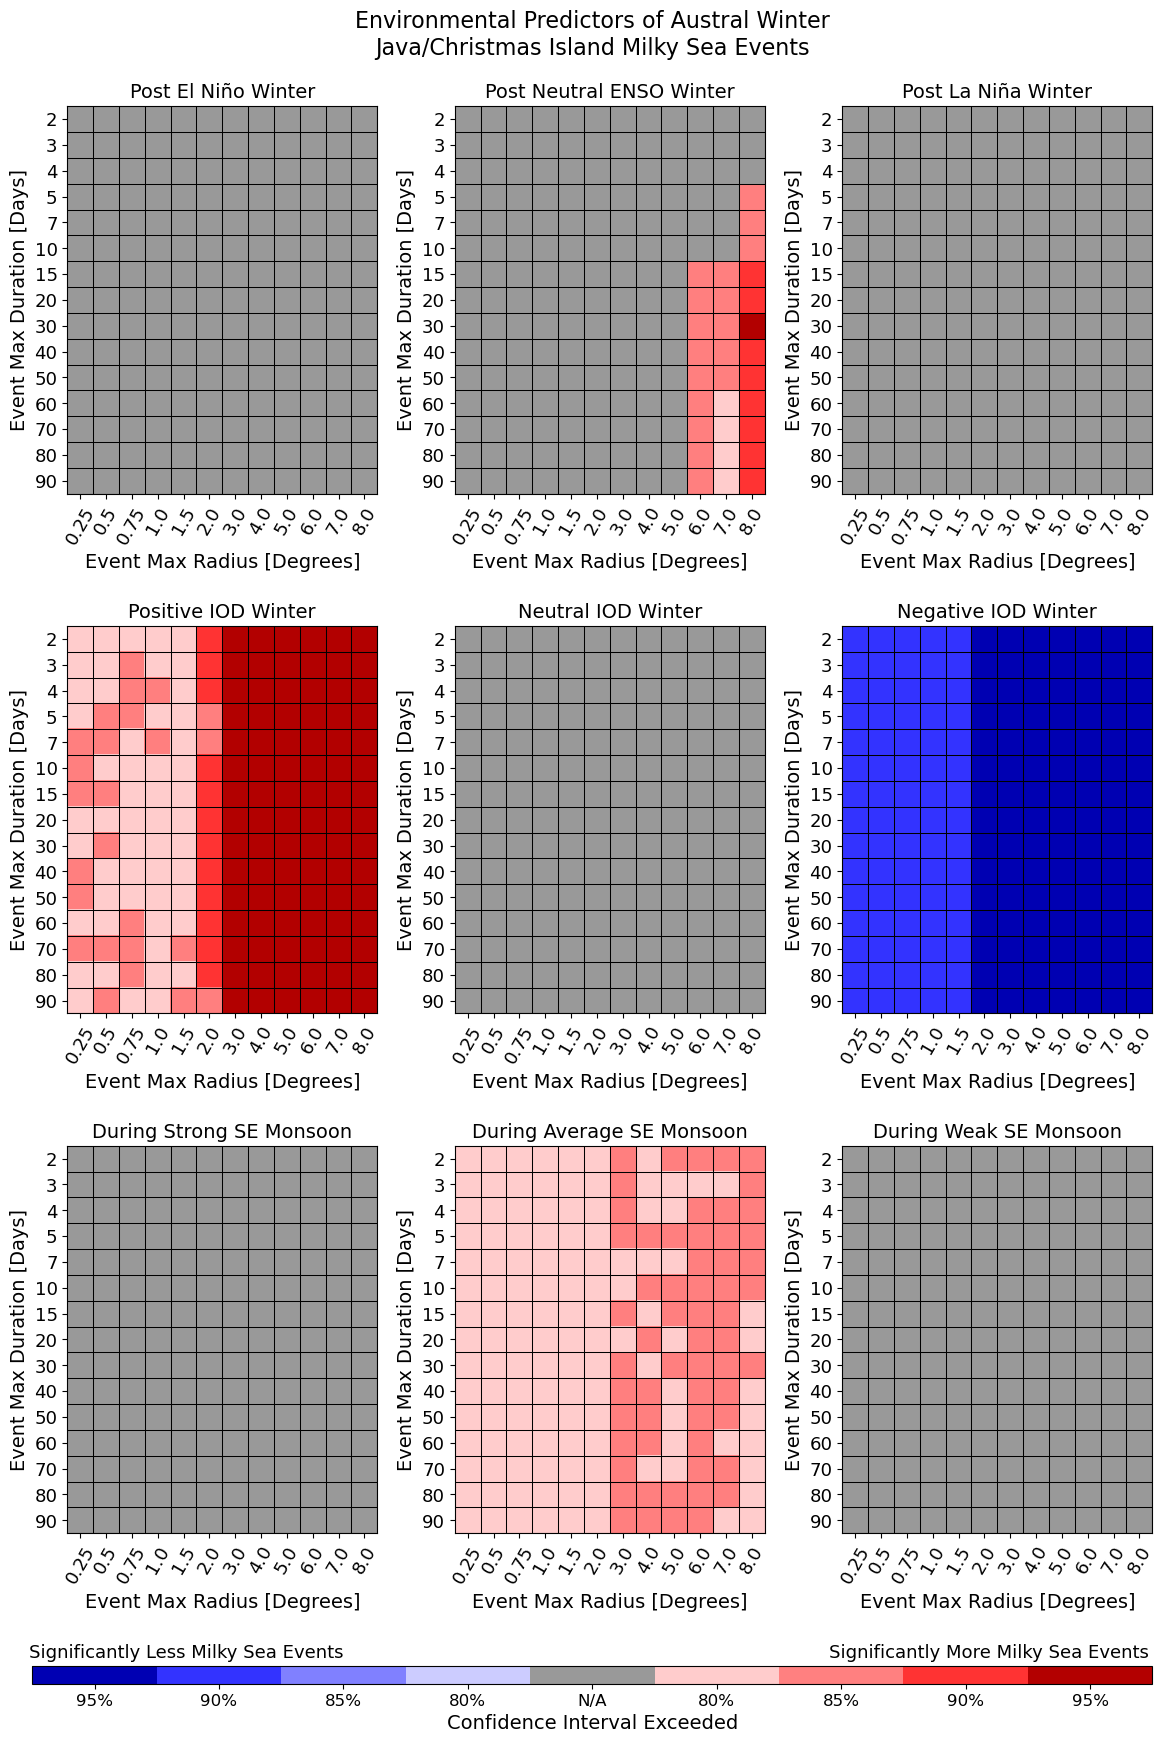

In [36]:
# now that I have the plot skeleton let's make one for Boreal Summer Arabian Sea Events
fig,ax = plt.subplots(3,3,figsize = (14,18))

#Fill in the images
im00 = ax[0,0].imshow(el_nino_codes[3],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im01 = ax[0,1].imshow(neutral_codes[3],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im02 = ax[0,2].imshow(la_nina_codes[3],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im10 = ax[1,0].imshow(pos_iod_codes[3],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im11 = ax[1,1].imshow(neu_iod_codes[3],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im12 = ax[1,2].imshow(neg_iod_codes[3],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im20 = ax[2,0].imshow(str_se_codes[3],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im21 = ax[2,1].imshow(ave_se_codes[3],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')
im22 = ax[2,2].imshow(weak_se_codes[3],cmap = custom_cmap,vmin = -4.5,vmax = 4.5,aspect = 'equal',interpolation = 'none')

#loop over the axes to add in details
for row in ax:
    for item in row:
        item.set_yticks(np.arange(0,len(day_distances)),day_distances,fontsize = 13)
        item.set_xticks(np.arange(0,len(deg_distances)),deg_distances,rotation = 60,fontsize = 13)
        item.set_ylabel("Event Max Duration [Days]",fontsize = 14)
        item.set_xlabel("Event Max Radius [Degrees]",fontsize = 14)
        for j in range(len(deg_distances)):
            item.axvline(j+0.5,color = 'k',linewidth = 0.75)
        for j in range(len(day_distances)):
            item.axhline(j+0.5,color = 'k',linewidth = 0.75)

#set up the colorbar axis
cax = fig.add_axes([0.1, 0.05, 0.8, 0.01]) #left bottom width height
cb = plt.colorbar(im00,cax=cax,ticks = [-4,-3,-2,-1,0,1,2,3,4],orientation = 'horizontal')
cb.set_ticklabels(['95%','90%','85%','80%','N/A','80%','85%','90%','95%'],fontsize = 12)
cb.set_label('Confidence Interval Exceeded',fontsize = 14)
#add in the titles for each axis
ax[0,0].set_title("Post El Niño Winter",fontsize = 14)
ax[0,1].set_title("Post Neutral ENSO Winter",fontsize = 14)
ax[0,2].set_title("Post La Niña Winter",fontsize = 14)
ax[1,0].set_title("Positive IOD Winter",fontsize = 14)
ax[1,1].set_title("Neutral IOD Winter",fontsize = 14)
ax[1,2].set_title("Negative IOD Winter",fontsize = 14)
ax[2,0].set_title("During Strong SE Monsoon",fontsize = 14)
ax[2,1].set_title("During Average SE Monsoon",fontsize = 14)
ax[2,2].set_title("During Weak SE Monsoon",fontsize = 14)
#add in some explanatory text
ax[2,1].text(-17,19.3,'Significantly Less Milky Sea Events',fontsize = 13)
ax[2,1].text(14,19.3,'Significantly More Milky Sea Events',fontsize = 13)

plt.suptitle("Environmental Predictors of Austral Winter\nJava/Christmas Island Milky Sea Events",fontsize = 16)

plt.subplots_adjust(wspace = 0.25,top = 0.95,hspace = 0.1)
plt.savefig("./FIGURES/Figure_12.jpg",dpi = 350,bbox_inches = 'tight')
plt.show()
